# #############################


# SECTION: Library Installations and GPU checks

In [2]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU (Metal) is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version: 2.18.0
Num GPUs Available: 1


# SECTION: Imports and more Libary Installs

In [3]:
# ! pip install tensorflow-datasets

In [4]:
! pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [181]:
# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow_datasets as tfds

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

import keras
import keras_tuner as kt

from keras import layers, models
from keras.optimizers import Adam
from tensorflow.keras import layers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.metrics import confusion_matrix

import joblib

# shap
#import shap

import openpyxl

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

# others
import re
from sklearn.decomposition import PCA
#from wordcloud import WordCloud
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


random.seed(42)
%matplotlib inline

# FILL IN CODE HERE #
RANDOM_SAMPLES_VAL = 100000 #To make computing on local machine, colab palatable, we will use a random sample for the exercise

# SECTION: Our helper and utility functions

In [6]:
#VS - II helpful functions

# summarizes a data frame in a printer friendly way
def summarize_dataframe(df):
    summary = pd.DataFrame({
        'Column Name': df.columns,
        'Data Type': df.dtypes.values,
        'Null Count': df.isnull().sum().values,
        'Non-Null Count': df.notnull().sum().values,
        'Unique Count': df.nunique().values
    })
    return summary

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras history object.

    Parameters:
    - history: Keras history object from model.fit()
    """

    epochs = range(1, len(history.history['loss']) + 1)

    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']


    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue', linestyle='-')
    ax[0].plot(epochs, val_loss, label='Validation Loss', color='red', linestyle='--')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, train_acc, label='Training Accuracy', color='blue', linestyle='-')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='red', linestyle='--')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# SECTION: Data Load

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
file_path = file_path = '/content/drive/MyDrive/ColabNotebooks/Churn.Models.Phase.2/e_commerce_dataset.xlsx'

In [9]:
! cd MyDrive

/bin/bash: line 1: cd: MyDrive: No such file or directory


# Data Load and basic EDA (EDA-Phase-0)
    Objectives:
        1) Load the data set and its data dictionary
        2) Assess shape of loaded data frame, numeric versus non numeric column types
        3) Assess null values
        4) Label class distribution

In [10]:
#Retail Data.csv is our master data file from Kaggle
ecomm_df= pd.read_excel(file_path, sheet_name="eComm", engine="openpyxl")


In [11]:
ecomm_df.shape

(5630, 20)

In [12]:
summarize_dataframe(ecomm_df).to_csv('my_ecomm_data_frame.csv')

In [13]:
#Data Dictionary
data_dict_df =  pd.read_excel(file_path, sheet_name="dataDict", engine="openpyxl")

In [14]:
columns = ['Variable','Description']
data_dict_df = data_dict_df.iloc[1:,2:4]
data_dict_df.columns = columns


In [15]:
data_dict_df

,Variable,Description
1,CustomerID,Unique customer ID
2,Churn,Churn Flag
3,Tenure,Tenure of customer in organization
4,PreferredLoginDevice,Preferred login device of customer
5,CityTier,City tier
6,WarehouseToHome,Distance in between warehouse to home of customer
7,PreferredPaymentMode,Preferred payment method of customer
8,Gender,Gender of customer
9,HourSpendOnApp,Number of hours spend on mobile application or...
10,NumberOfDeviceRegistered,Total number of deceives is registered on part...


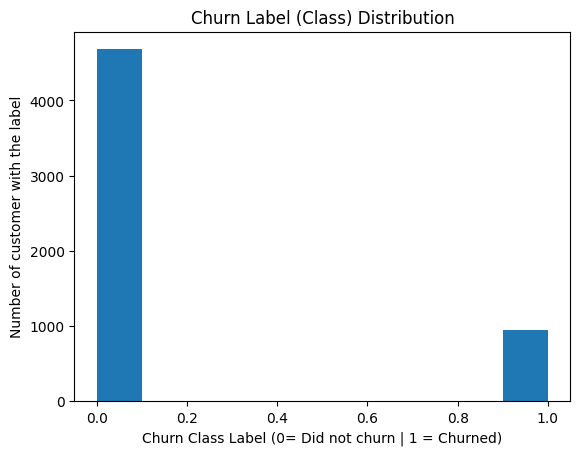

In [16]:
plt.hist(ecomm_df['Churn'])
plt.title('Churn Label (Class) Distribution')
plt.ylabel("Number of customer with the label")
plt.xlabel("Churn Class Label (0= Did not churn | 1 = Churned)")
plt.show()

In [17]:
num_not_churned = np.sum(ecomm_df['Churn'] == 0)
num_churned = np.sum(ecomm_df['Churn'] == 1)
num_total_customers = num_churned + num_not_churned

print("_"*125)
print("Churned versus not churned customers distribution, Original Data set")
print("_"*125)
print(f" Total number of customers: { num_total_customers}")
print(f" Total number of NOT churned customers: { num_not_churned } , { round((num_not_churned / num_total_customers )*100,2)}% ")
print(f" Total number of churned customers: { num_churned } , { round((num_churned / num_total_customers )*100,2)}% ")
print("_"*125)
print("_"*125)

_____________________________________________________________________________________________________________________________
Churned versus not churned customers distribution, Original Data set
_____________________________________________________________________________________________________________________________
 Total number of customers: 5630
 Total number of NOT churned customers: 4682 , 83.16% 
 Total number of churned customers: 948 , 16.84% 
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


In [18]:
summarize_dataframe(ecomm_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CustomerID,int64,0,5630,5630
1,Churn,int64,0,5630,2
2,Tenure,float64,264,5366,36
3,PreferredLoginDevice,object,0,5630,3
4,CityTier,int64,0,5630,3
5,WarehouseToHome,float64,251,5379,34
6,PreferredPaymentMode,object,0,5630,7
7,Gender,object,0,5630,2
8,HourSpendOnApp,float64,255,5375,6
9,NumberOfDeviceRegistered,int64,0,5630,6


In [19]:
ecomm_df.isna().sum().sum()

np.int64(1856)

In [20]:
summarize_dataframe(ecomm_df)[summarize_dataframe(ecomm_df)['Null Count'] != 0 ]

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
2,Tenure,float64,264,5366,36
5,WarehouseToHome,float64,251,5379,34
8,HourSpendOnApp,float64,255,5375,6
15,OrderAmountHikeFromlastYear,float64,265,5365,16
16,CouponUsed,float64,256,5374,17
17,OrderCount,float64,258,5372,16
18,DaySinceLastOrder,float64,307,5323,22


In [21]:
ecomm_df.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [22]:
ecomm_df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [23]:
ecomm_df

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5625,55626,0,10.0,Computer,1,30.0,Credit Card,Male,3.0,2,Laptop & Accessory,1,Married,6,0,18.0,1.0,2.0,4.0,150.71
5626,55627,0,13.0,Mobile Phone,1,13.0,Credit Card,Male,3.0,5,Fashion,5,Married,6,0,16.0,1.0,2.0,NaN,224.91
5627,55628,0,1.0,Mobile Phone,1,11.0,Debit Card,Male,3.0,2,Laptop & Accessory,4,Married,3,1,21.0,1.0,2.0,4.0,186.42
5628,55629,0,23.0,Computer,3,9.0,Credit Card,Male,4.0,5,Laptop & Accessory,4,Married,4,0,15.0,2.0,2.0,9.0,178.90


# Findings Data Load and basic EDA (EDA-Phase-0)
    Objectives:
        1) Load the data set and its data dictionary
        2) Assess shape of loaded data frame, numeric versus non numeric column types
        3) Assess null values
        4) Label class distribution
    Findings:
        Findings:

            Shape of data set: (5,630, 20): 5,520 rows and 20 columns
            All columns are numeric, except 5, which are categorical:
                PreferredLoginDevice, PreferredPaymentMode, Gender, PreferredOrderCat, MaritalStatus

            There are 1856 null values across 7 columns, all of which are numeric.
            Churned-versus-not-churned class distribution is appx. 17%-83%


# EDA-Phase-I
    Objectives:
        1) Handle missing values in data set
        2) Convert categorical values to numeric
        3) Look at correlation matrix
        4) Reject highly correlated features (e.g. if abs(correlation value)>threshold). Retain only one feature of correlated pair.
        5) Further down select by selecting features that have high abs(correlation) with churn, and using domain understanding


In [24]:
# 1 Handle missing values in data set
summarize_dataframe(ecomm_df)[summarize_dataframe(ecomm_df)['Null Count'] != 0 ]

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
2,Tenure,float64,264,5366,36
5,WarehouseToHome,float64,251,5379,34
8,HourSpendOnApp,float64,255,5375,6
15,OrderAmountHikeFromlastYear,float64,265,5365,16
16,CouponUsed,float64,256,5374,17
17,OrderCount,float64,258,5372,16
18,DaySinceLastOrder,float64,307,5323,22


In [25]:
ecomm_df.isnull().any(axis=0).shape[0]

20

In [26]:
# Find rows with missing values
missing_rows = ecomm_df[ecomm_df.isnull().any(axis=1)]
# Count missing values per row
missing_count_per_row = ecomm_df.isnull().sum(axis=1)
total_rows = ecomm_df.shape[0]
print("_"*125)
print("Missing row analysis")
print("_"*125)
print(f" Total number of rows: { total_rows}")
print(f" Total number of rows that have missing values: { missing_rows.shape[0]}")
print(f" Maximum count of missing values per row: { max(missing_count_per_row)}")

_____________________________________________________________________________________________________________________________
Missing row analysis
_____________________________________________________________________________________________________________________________
 Total number of rows: 5630
 Total number of rows that have missing values: 1856
 Maximum count of missing values per row: 1


# Our Basis for misssing value imputation
    Rows can be dropped that have missing values, if their percentage is small. In our case, the total number of rows that are missing values are 1856 (33% of total rows). So we cannot drop, missing value rows as we will lose 33% of our data.

    Can we drop rows that have a lot of missing values? Also no, since maximum count of missing values per row is 1.

    So we look towards missing value imputation, and use the following guidelines.
        Mean imputation works well when the data is approximately normally distributed, meaning it has a symmetrical distribution without signiﬁcant skew or outliers.
        Median imputation is useful when the data is skewed or has outliers. In these cases, the median is less afected by extreme values and provides a better central tendency estimate.
    
    So, to decide which imputation to use lets look at the univariate distribution

<Figure size 640x480 with 0 Axes>

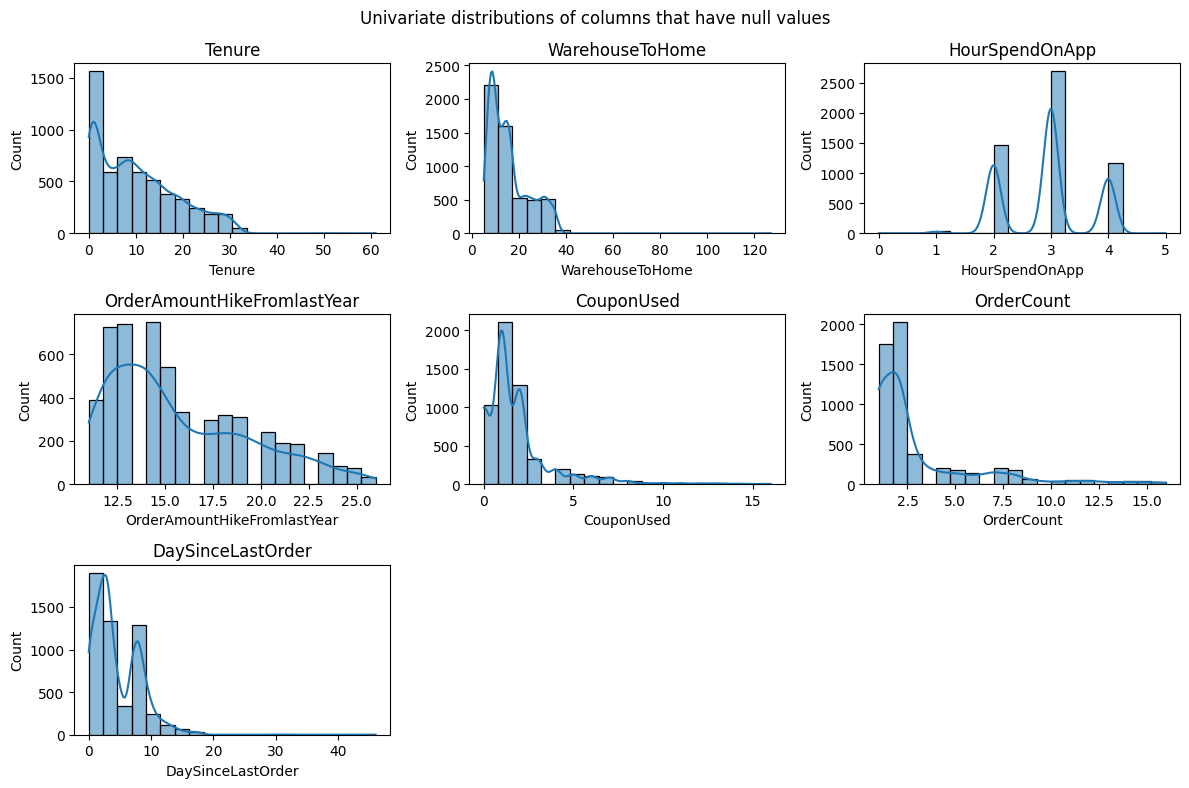

In [27]:
null_df = summarize_dataframe(ecomm_df)[summarize_dataframe(ecomm_df)['Null Count'] != 0 ]
null_cols = list(null_df['Column Name'].values)
null_df = ecomm_df[null_cols]
plt.clf()
plt.figure(figsize=(12, 8))
for i, col in enumerate(null_cols, 1):
    plt.subplot(3, 3, i)  # Adjust grid size if needed
    sns.histplot(ecomm_df[col], bins=20, kde=True, edgecolor='black')
    plt.title(col)
plt.suptitle("Univariate distributions of columns that have null values")
plt.tight_layout()
plt.show()

# Comment on plot above
    None of the columns of normal distribution, making mean imputation inappropriate. Plus all of them have outliers. So we will use Median imputation, which is suitabkle for skewed distributions and is more robist to outliers.

In [28]:
null_cols

['Tenure',
 'WarehouseToHome',
 'HourSpendOnApp',
 'OrderAmountHikeFromlastYear',
 'CouponUsed',
 'OrderCount',
 'DaySinceLastOrder']

In [29]:
# Median imputation
imputer = SimpleImputer(strategy="median")
ecomm_df[null_cols]=imputer.fit_transform(ecomm_df[null_cols])

In [30]:
summarize_dataframe(ecomm_df)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CustomerID,int64,0,5630,5630
1,Churn,int64,0,5630,2
2,Tenure,float64,0,5630,36
3,PreferredLoginDevice,object,0,5630,3
4,CityTier,int64,0,5630,3
5,WarehouseToHome,float64,0,5630,34
6,PreferredPaymentMode,object,0,5630,7
7,Gender,object,0,5630,2
8,HourSpendOnApp,float64,0,5630,6
9,NumberOfDeviceRegistered,int64,0,5630,6


#
    As above outout shows, all our null or missing vaulues have been median imputed.
    Now we move to EDA Phase-I Step 2: Convert categorical values to numeric.

In [31]:
# Unique values of categorical colums
categorical_cols = ['PreferredLoginDevice', 'PreferredPaymentMode', 'Gender', 'PreferedOrderCat', 'MaritalStatus']
for col in categorical_cols:
    print(f"Column: {col} | Unique values : { np.unique(ecomm_df[col])} ")

Column: PreferredLoginDevice | Unique values : ['Computer' 'Mobile Phone' 'Phone'] 
Column: PreferredPaymentMode | Unique values : ['CC' 'COD' 'Cash on Delivery' 'Credit Card' 'Debit Card' 'E wallet' 'UPI'] 
Column: Gender | Unique values : ['Female' 'Male'] 
Column: PreferedOrderCat | Unique values : ['Fashion' 'Grocery' 'Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others'] 
Column: MaritalStatus | Unique values : ['Divorced' 'Married' 'Single'] 


In [32]:
continuous_cols = ecomm_df.columns.difference(categorical_cols)
continuous_cols

Index(['CashbackAmount', 'Churn', 'CityTier', 'Complain', 'CouponUsed',
       'CustomerID', 'DaySinceLastOrder', 'HourSpendOnApp', 'NumberOfAddress',
       'NumberOfDeviceRegistered', 'OrderAmountHikeFromlastYear', 'OrderCount',
       'SatisfactionScore', 'Tenure', 'WarehouseToHome'],
      dtype='object')

In [33]:
#extract continuous columns; extract categorical columns; one hot encode cat columns; get encoded data frame;
# concatenate continuous data frame + encode data frame to get final encoded ecomm_df_encoded
ecomm_df_cont = ecomm_df[continuous_cols]
ecomm_df_cat = ecomm_df[categorical_cols]

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cat_array = encoder.fit_transform(ecomm_df_cat)

In [34]:
print(encoded_cat_array[:2])
print(encoder.get_feature_names_out(categorical_cols))
encoded_col_names = encoder.get_feature_names_out(categorical_cols)

[[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1.]]
['PreferredLoginDevice_Mobile Phone' 'PreferredLoginDevice_Phone'
 'PreferredPaymentMode_COD' 'PreferredPaymentMode_Cash on Delivery'
 'PreferredPaymentMode_Credit Card' 'PreferredPaymentMode_Debit Card'
 'PreferredPaymentMode_E wallet' 'PreferredPaymentMode_UPI' 'Gender_Male'
 'PreferedOrderCat_Grocery' 'PreferedOrderCat_Laptop & Accessory'
 'PreferedOrderCat_Mobile' 'PreferedOrderCat_Mobile Phone'
 'PreferedOrderCat_Others' 'MaritalStatus_Married' 'MaritalStatus_Single']


In [35]:
encoded_cat_df = pd.DataFrame(encoded_cat_array, columns=encoded_col_names)
encoded_cat_df.head()

,PreferredLoginDevice_Mobile Phone,PreferredLoginDevice_Phone,PreferredPaymentMode_COD,PreferredPaymentMode_Cash on Delivery,PreferredPaymentMode_Credit Card,PreferredPaymentMode_Debit Card,PreferredPaymentMode_E wallet,PreferredPaymentMode_UPI,Gender_Male,PreferedOrderCat_Grocery,PreferedOrderCat_Laptop & Accessory,PreferedOrderCat_Mobile,PreferedOrderCat_Mobile Phone,PreferedOrderCat_Others,MaritalStatus_Married,MaritalStatus_Single
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [36]:
print(f"{ encoded_cat_df.shape = }, { ecomm_df_cont.shape = }, {ecomm_df.shape = }")

 encoded_cat_df.shape = (5630, 16),  ecomm_df_cont.shape = (5630, 15), ecomm_df.shape = (5630, 20)


In [37]:
ecomm_df_encoded = pd.concat([ecomm_df_cont,encoded_cat_df],axis=1)
print(f" { ecomm_df_encoded.shape = }")

  ecomm_df_encoded.shape = (5630, 31)


In [38]:
ecomm_df_encoded.columns

Index(['CashbackAmount', 'Churn', 'CityTier', 'Complain', 'CouponUsed',
       'CustomerID', 'DaySinceLastOrder', 'HourSpendOnApp', 'NumberOfAddress',
       'NumberOfDeviceRegistered', 'OrderAmountHikeFromlastYear', 'OrderCount',
       'SatisfactionScore', 'Tenure', 'WarehouseToHome',
       'PreferredLoginDevice_Mobile Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Cash on Delivery',
       'PreferredPaymentMode_Credit Card', 'PreferredPaymentMode_Debit Card',
       'PreferredPaymentMode_E wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop & Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')

In [39]:
#Standardize column names
def clean_column_names(columns):
    return columns.str.replace(' ', '_').str.replace('&', 'and').str.replace('-', '_')

ecomm_df_encoded.columns = clean_column_names(ecomm_df_encoded.columns)

# Display the updated column names
print(ecomm_df_encoded.columns)

Index(['CashbackAmount', 'Churn', 'CityTier', 'Complain', 'CouponUsed',
       'CustomerID', 'DaySinceLastOrder', 'HourSpendOnApp', 'NumberOfAddress',
       'NumberOfDeviceRegistered', 'OrderAmountHikeFromlastYear', 'OrderCount',
       'SatisfactionScore', 'Tenure', 'WarehouseToHome',
       'PreferredLoginDevice_Mobile_Phone', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'PreferredPaymentMode_Cash_on_Delivery',
       'PreferredPaymentMode_Credit_Card', 'PreferredPaymentMode_Debit_Card',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_UPI',
       'Gender_Male', 'PreferedOrderCat_Grocery',
       'PreferedOrderCat_Laptop_and_Accessory', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Mobile_Phone', 'PreferedOrderCat_Others',
       'MaritalStatus_Married', 'MaritalStatus_Single'],
      dtype='object')


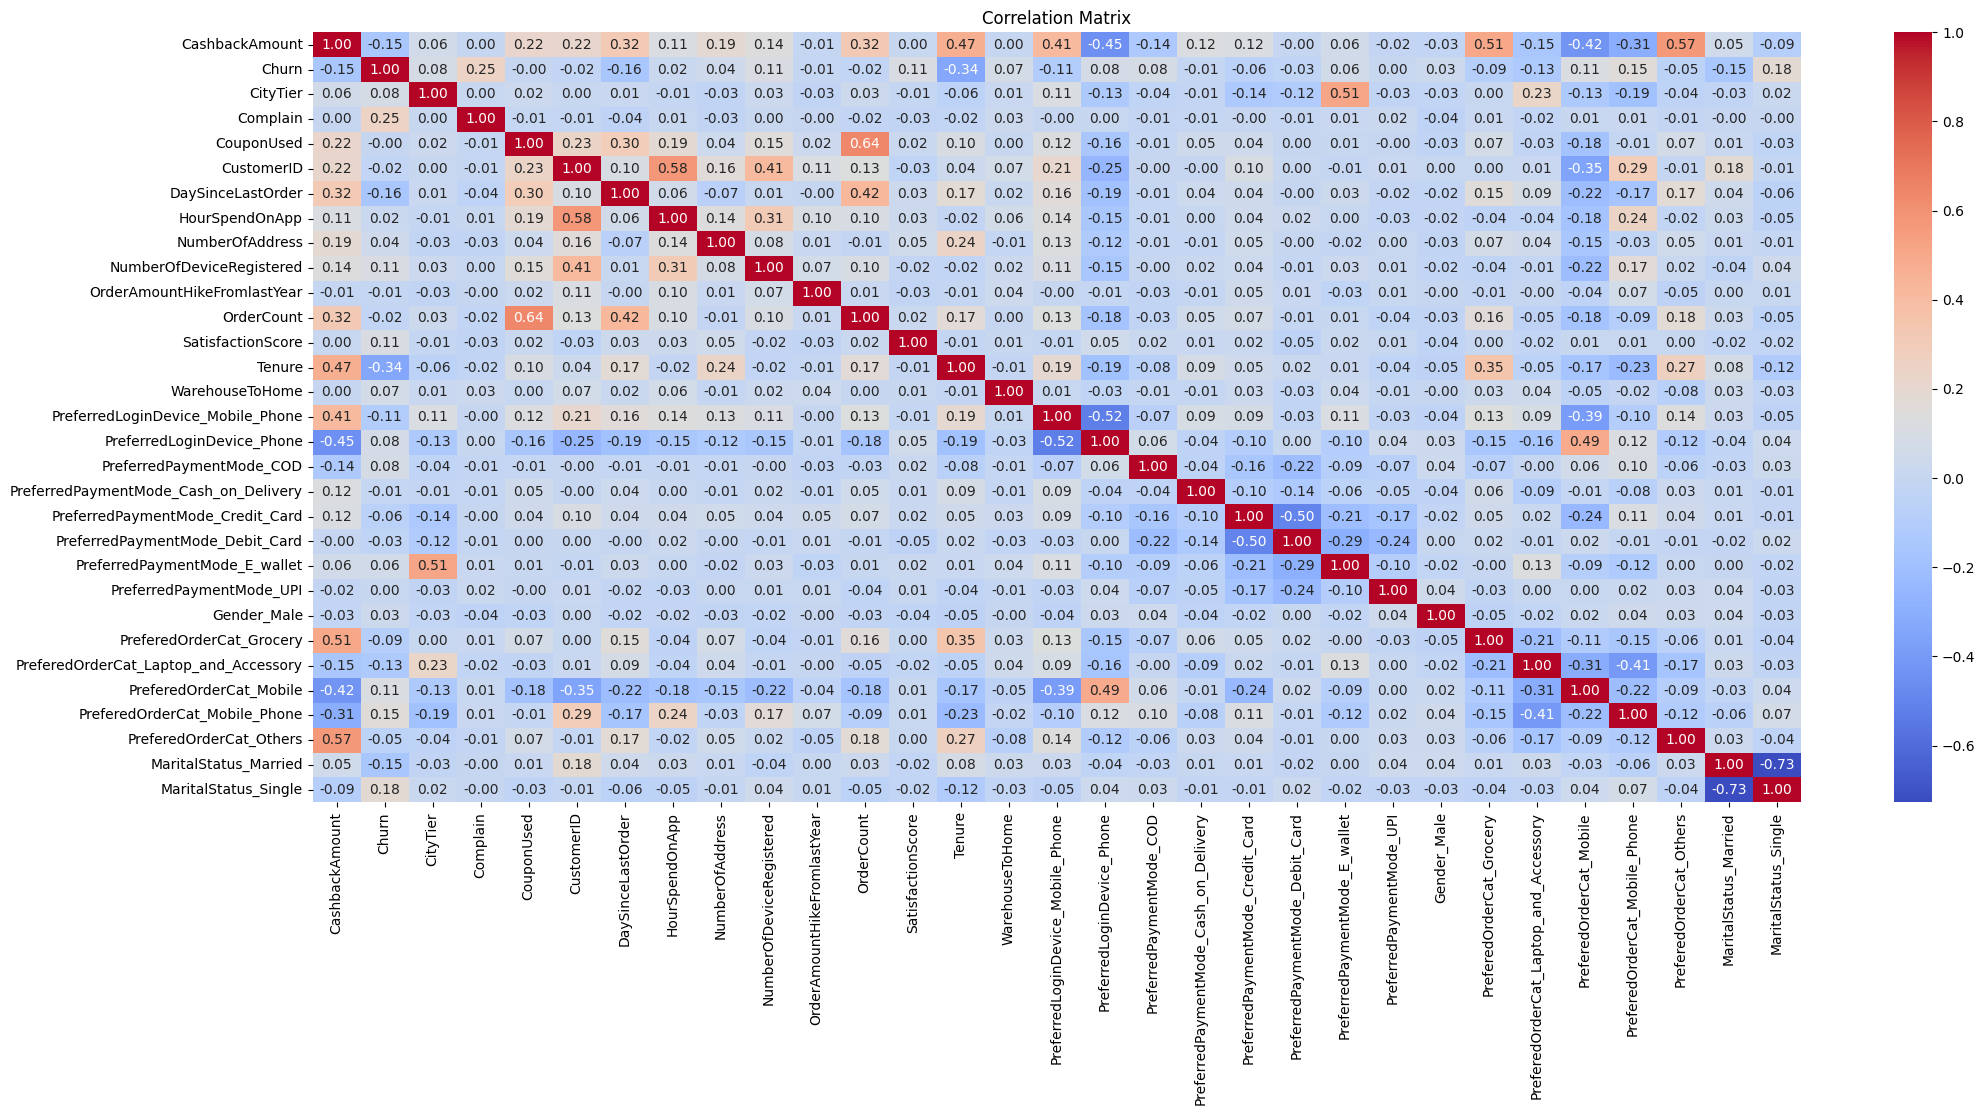

In [40]:
#Visualize correlaion matrix
correlation_matrix = ecomm_df_encoded.corr()
plt.figure(figsize=(24, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Correlation matrix based feature down selection

    4. abs(correlation value) = 0.6 seems to be a good threshold to use to down select from feature pairs that have high correlation value.

    4.1 Marital status married, and single are highly correlated (absolute value = 0.73), but married single has relatively higher abs(correaltion value) with churn (0.18, to 0.15). So from this pair, we will drop MaritalStatus_Married.

    4.2. Similarly, between order count and coupon used, order count makes the cut, and coupon used is dropped.

In [41]:
drop_col_names = ['MaritalStatus_Married','CouponUsed']

#ecomm_df_encoded_B is ecomm_df_encoded with dropped highly correlated features
ecomm_df_encoded_B = ecomm_df_encoded.drop(columns=drop_col_names)

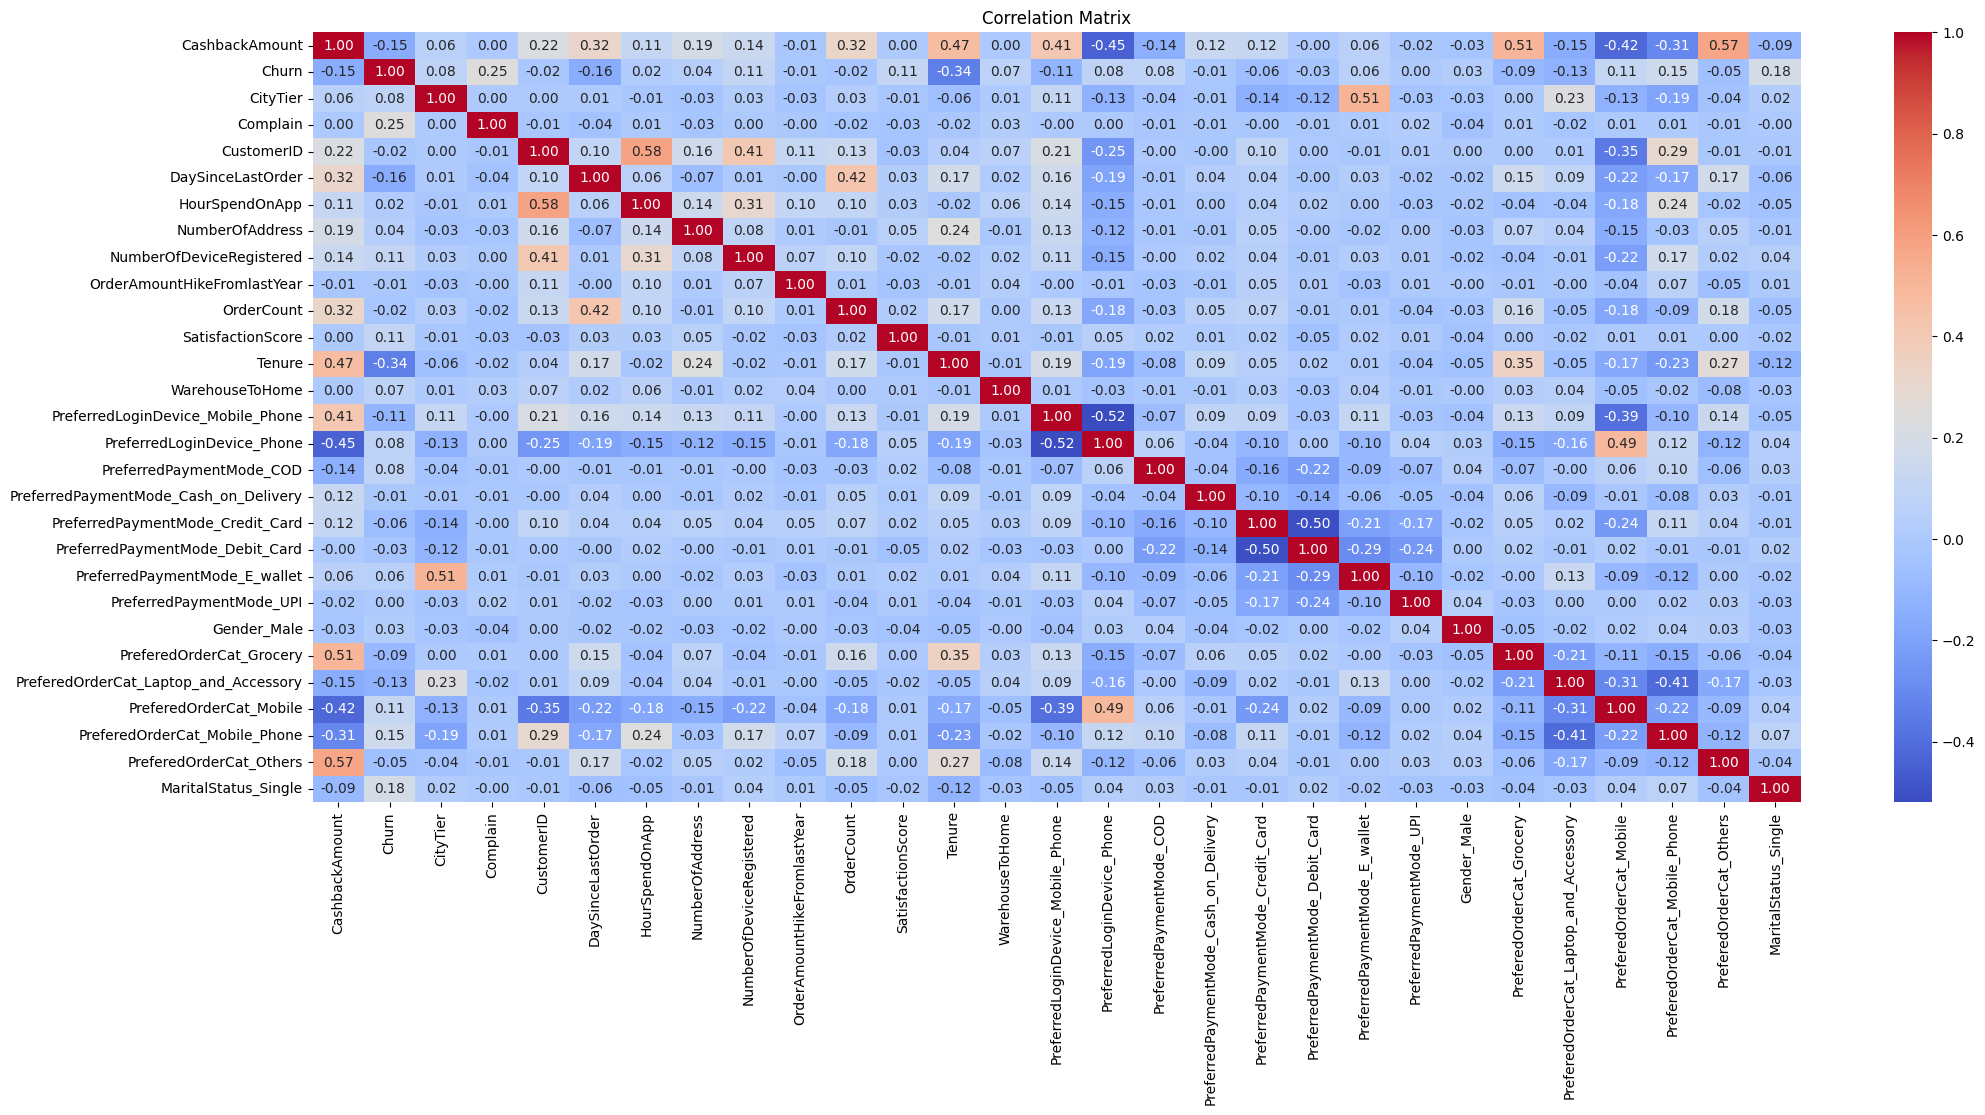

In [42]:
#Visualize correlaion matrix
correlation_matrix = ecomm_df_encoded_B.corr()
plt.figure(figsize=(24, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [43]:
abs(correlation_matrix.loc['Churn']).sort_values()

,Churn
PreferredPaymentMode_UPI,0.004163
PreferredPaymentMode_Cash_on_Delivery,0.006178
OrderAmountHikeFromlastYear,0.007075
HourSpendOnApp,0.018816
CustomerID,0.019083
OrderCount,0.024038
Gender_Male,0.029264
PreferredPaymentMode_Debit_Card,0.032453
NumberOfAddress,0.043931
PreferedOrderCat_Others,0.054903


In [44]:
abs(correlation_matrix.loc['Churn']).sort_values().index

Index(['PreferredPaymentMode_UPI', 'PreferredPaymentMode_Cash_on_Delivery',
       'OrderAmountHikeFromlastYear', 'HourSpendOnApp', 'CustomerID',
       'OrderCount', 'Gender_Male', 'PreferredPaymentMode_Debit_Card',
       'NumberOfAddress', 'PreferedOrderCat_Others',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_Credit_Card',
       'WarehouseToHome', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'CityTier', 'PreferedOrderCat_Grocery',
       'SatisfactionScore', 'NumberOfDeviceRegistered',
       'PreferredLoginDevice_Mobile_Phone', 'PreferedOrderCat_Mobile',
       'PreferedOrderCat_Laptop_and_Accessory', 'CashbackAmount',
       'PreferedOrderCat_Mobile_Phone', 'DaySinceLastOrder',
       'MaritalStatus_Single', 'Complain', 'Tenure', 'Churn'],
      dtype='object')

# Next we will drop features that have low abs(correlation) with the churn label, and then assess this new set for domain accuracy (does the feature make sense from a domain knowledge)
    # from output above that shows abs(corr) of all features with churn, we will use abs(cor) >= 0.1 as the threshold for feature selection.
    This gives us 11 features.
    From this we will remove PreferedOrderCat_Mobile that seems to be similar to PreferedOrderCat_Mobile Phone.
     



In [45]:
ecomm_df_encoded_C = ecomm_df_encoded_B.drop(columns=['PreferedOrderCat_Mobile','PreferredPaymentMode_UPI', 'PreferredPaymentMode_Cash_on_Delivery',
       'OrderAmountHikeFromlastYear', 'HourSpendOnApp', 'CustomerID',
       'OrderCount', 'Gender_Male', 'PreferredPaymentMode_Debit_Card',
       'NumberOfAddress', 'PreferedOrderCat_Others',
       'PreferredPaymentMode_E_wallet', 'PreferredPaymentMode_Credit_Card',
       'WarehouseToHome', 'PreferredLoginDevice_Phone',
       'PreferredPaymentMode_COD', 'CityTier', 'PreferedOrderCat_Grocery'])

In [46]:
correlation_matrix = ecomm_df_encoded_C.corr()
abs(correlation_matrix.loc['Churn']).sort_values()

,Churn
SatisfactionScore,0.105481
NumberOfDeviceRegistered,0.107939
PreferredLoginDevice_Mobile_Phone,0.111639
PreferedOrderCat_Laptop_and_Accessory,0.133353
CashbackAmount,0.154118
PreferedOrderCat_Mobile_Phone,0.154387
DaySinceLastOrder,0.155871
MaritalStatus_Single,0.180847
Complain,0.250188
Tenure,0.337831


In [47]:
summarize_dataframe(ecomm_df_encoded_C)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CashbackAmount,float64,0,5630,2586
1,Churn,int64,0,5630,2
2,Complain,int64,0,5630,2
3,DaySinceLastOrder,float64,0,5630,22
4,NumberOfDeviceRegistered,int64,0,5630,6
5,SatisfactionScore,int64,0,5630,5
6,Tenure,float64,0,5630,36
7,PreferredLoginDevice_Mobile_Phone,float64,0,5630,2
8,PreferedOrderCat_Laptop_and_Accessory,float64,0,5630,2
9,PreferedOrderCat_Mobile_Phone,float64,0,5630,2


In [48]:
ecomm_df_encoded_C.shape

(5630, 11)

In [49]:
Y_dataset = ecomm_df_encoded_C.pop('Churn')
Y_dataset = Y_dataset.to_numpy()

In [50]:
X_dataset = ecomm_df_encoded_C.copy()

In [51]:
print("_"*125)
print(" Our master training data set")
print("_"*125)
print(f" Shape of X_dataset : { X_dataset.shape }")
print(f" Shape of Y_dataset : { Y_dataset.shape }")
print("_"*125)
print("_"*125)

_____________________________________________________________________________________________________________________________
 Our master training data set
_____________________________________________________________________________________________________________________________
 Shape of X_dataset : (5630, 10)
 Shape of Y_dataset : (5630,)
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


In [52]:
X_dataset.columns

Index(['CashbackAmount', 'Complain', 'DaySinceLastOrder',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'Tenure',
       'PreferredLoginDevice_Mobile_Phone',
       'PreferedOrderCat_Laptop_and_Accessory',
       'PreferedOrderCat_Mobile_Phone', 'MaritalStatus_Single'],
      dtype='object')

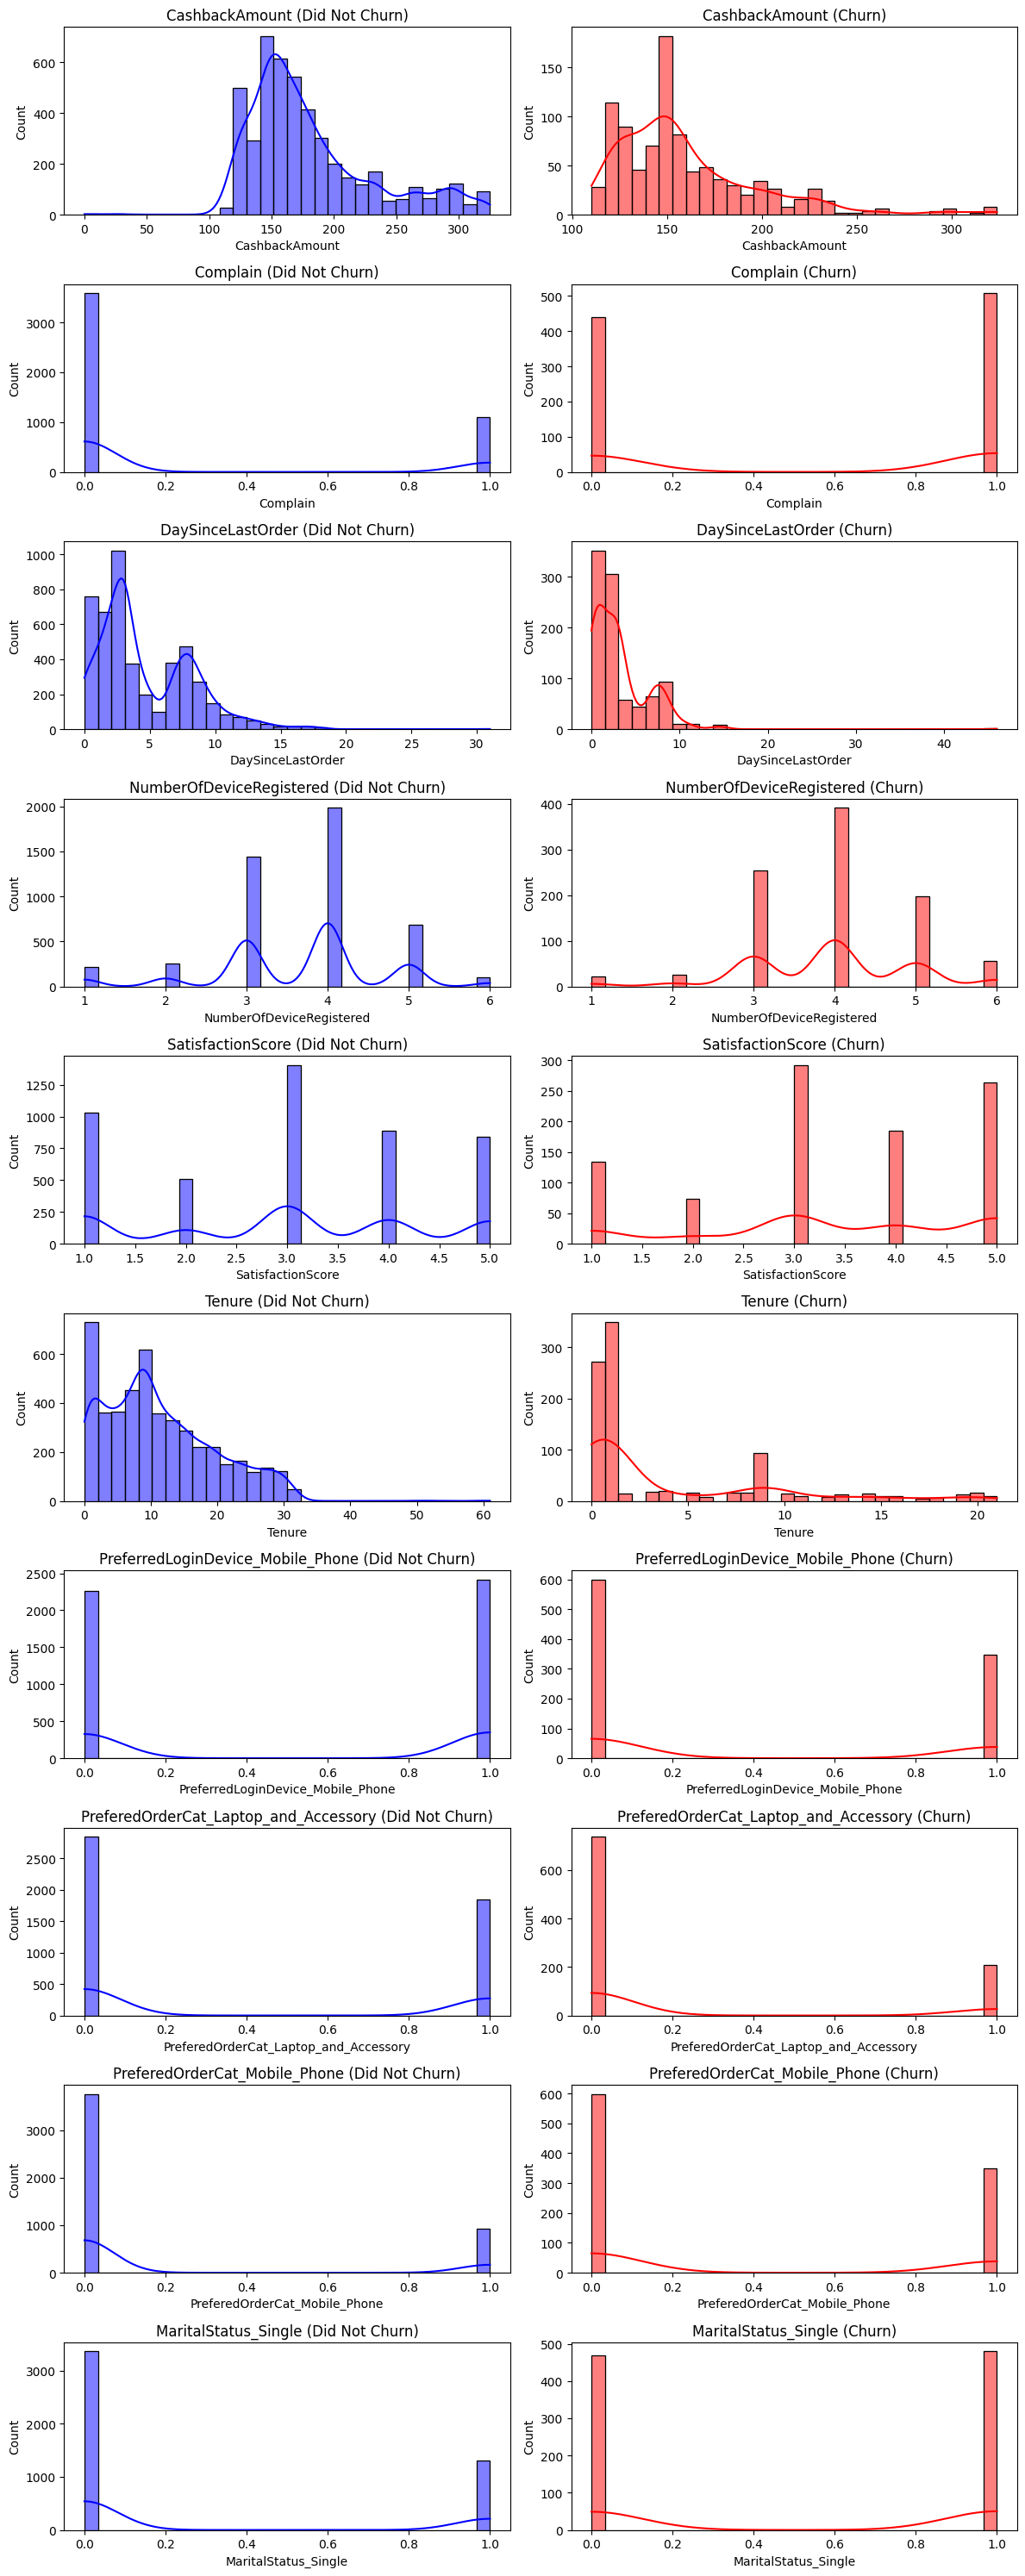

In [53]:
#Lets visualize distributionof each feature for each class label.
#Distributions that are similar for the two class values will not provide much information to the model

features = [
    'CashbackAmount', 'Complain', 'DaySinceLastOrder', 'NumberOfDeviceRegistered',
    'SatisfactionScore', 'Tenure', 'PreferredLoginDevice_Mobile_Phone',
    'PreferedOrderCat_Laptop_and_Accessory', 'PreferedOrderCat_Mobile_Phone',
    'MaritalStatus_Single'
]

# Number of rows and columns for subplots
num_features = len(features)
rows = num_features  # One row per feature
cols = 2  # Two columns: One for each class (churn = 0 and churn = 1)

fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 3))

# Loop through features and plot side-by-side histograms
for i, feature in enumerate(features):
    # Plot histogram for Y = 0 (Did Not Churn)
    sns.histplot(
        data=X_dataset[Y_dataset == 0], x=feature, bins=30, kde=True, color="blue", ax=axes[i, 0]
    )
    axes[i, 0].set_title(f'{feature} (Did Not Churn)')

    # Plot histogram for Y = 1 (Churn)
    sns.histplot(
        data=X_dataset[Y_dataset == 1], x=feature, bins=30, kde=True, color="red", ax=axes[i, 1]
    )
    axes[i, 1].set_title(f'{feature} (Churn)')

# Adjust layout
plt.tight_layout()
plt.show()



# Comparing distribution of each feature across the two class labels

    Findings:

        Distribution of all features are dissimilar across the two class labels (churn, did not churn) except for one feature (‘NumberOfDeviceRegistered’), indicating that all features except for ‘NumberOfDeviceRegistered’ can contribute information to the model.

        So, we will drop ‘NumberOfDeviceRegistered’

In [54]:
print(X_dataset.shape)
X_dataset.columns

(5630, 10)


Index(['CashbackAmount', 'Complain', 'DaySinceLastOrder',
       'NumberOfDeviceRegistered', 'SatisfactionScore', 'Tenure',
       'PreferredLoginDevice_Mobile_Phone',
       'PreferedOrderCat_Laptop_and_Accessory',
       'PreferedOrderCat_Mobile_Phone', 'MaritalStatus_Single'],
      dtype='object')

In [55]:
X_dataset = X_dataset.drop(columns=['NumberOfDeviceRegistered'])

In [56]:
print(X_dataset.shape)
X_dataset.columns

(5630, 9)


Index(['CashbackAmount', 'Complain', 'DaySinceLastOrder', 'SatisfactionScore',
       'Tenure', 'PreferredLoginDevice_Mobile_Phone',
       'PreferedOrderCat_Laptop_and_Accessory',
       'PreferedOrderCat_Mobile_Phone', 'MaritalStatus_Single'],
      dtype='object')

In [57]:
print("_"*125)
print(" Our master training data set")
print("_"*125)
print(f" Shape of X_dataset : { X_dataset.shape }")
print(f" Shape of Y_dataset : { Y_dataset.shape }")
print("_"*125)
print("_"*125)

_____________________________________________________________________________________________________________________________
 Our master training data set
_____________________________________________________________________________________________________________________________
 Shape of X_dataset : (5630, 9)
 Shape of Y_dataset : (5630,)
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


  #
    Plot histogram of Churned column to see if class distribution is imbalanced

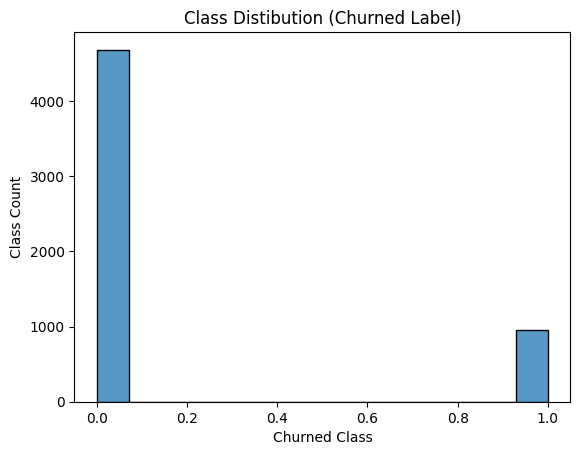

In [58]:
sns.histplot(Y_dataset)
plt.xlabel('Churned Class')
plt.ylabel('Class Count')
plt.title('Class Distibution (Churned Label)')
plt.show()

In [59]:
num_churned, num_not_churned, num_total_customers = np.sum(Y_dataset == 1), np.sum(Y_dataset ==0), len(Y_dataset)
perc_churned = round((num_churned / num_total_customers) * 100, 2)
perc_not_churned = round((num_not_churned / num_total_customers) * 100, 2)
print(f"Churned: {perc_churned}%")
print(f"Not Churned: {perc_not_churned}%")

Churned: 16.84%
Not Churned: 83.16%


# Class Imbalance analysis, findings and approach
    Our class distribution is unbalanced. 83.16% of the customers have not churned. So, a naive model that just predicts ‘will not churn’ will be 83.16% accurate.

    To prevent our models from learning too much from the majority class, we need to mitigate this class imbalance.

    Two strategies are: oversample from minority class by creating synthetic data, or under sample from majority class.

    Latter approach is not preferred since our data set is modest sized, and we may lose information.

    Oversampling may be ok, because our data set is modest, and creating more samples may not reduce the model speed a lot. We will use SMOTE oversampling that will increase samples from minority class to be 40% of total. SMOTE uses nearest neighbors to generate new samples between existing points.



# But to prevent data leakage we will apply SMOTE after splitting and ONLY to training data set and not to validation and test data sets.

    Planned  Workflow
    1. Split data:
        First, split X_train into train, validation, and test (without SMOTE).
    2. Apply SMOTE: Only apply SMOTE on the training set.
    3. Train the model: Use the resampled training set but evaluate on the original validation and test sets.

# POST THIS PREVIOUS TO APR 2 2025

# Towards X_dataset construction
   


# Workflow:
    1) Split the data into train, val, and test (75,15,15).
        Using 75-15-15 split (versus 60-20-20) since our data set is modest and to give enough samples for training and SMOTE
    2) Apply SMOTE to train data set
        Sampling stratgey of 0.4 brings churners to 40% of the majority class (appx. brings churners from 17% to ~29%, improving balance while still
        keeping data realistic.)
    3) Std scale (fit) on SMOTEd train data. Use mean and std dev of train data to std scale val, and test data
        - This prevents data leakage from test to train.

In [60]:
# Train (70%) and Temp (30%) split
X_train_orig, X_temp, Y_train_orig, Y_temp = train_test_split(X_dataset, Y_dataset, test_size=0.3, random_state=42, stratify=Y_dataset)

# Split Temp into Validation (15%) and Test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE on Training Set Only
smote = SMOTE(sampling_strategy=0.4, random_state=42)
X_train, y_train = smote.fit_resample(X_train_orig, Y_train_orig)



# Note: X_train, Y_train are SMOTE resampled.

In [61]:
# Post SMOTE class distrubution
num_churned, num_not_churned, num_total_customers = np.sum(y_train == 1), np.sum(y_train ==0), len(y_train)
perc_churned = round((num_churned / num_total_customers) * 100, 2)
perc_not_churned = round((num_not_churned / num_total_customers) * 100, 2)
print(f"Churned: {perc_churned}%")
print(f"Not Churned: {perc_not_churned}%")

Churned: 28.56%
Not Churned: 71.44%


# Post SMOTE our training class distribution is (71-29), more blanced than 83-17 in original data set

In [62]:
print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train) = }, { X_train.shape = }, { type(y_train) = } , { y_train.shape = }")
print(f"{ type(X_val) = }, { X_val.shape = }, { type(y_val) = } , { y_val.shape = }")
print(f"{ type(X_test) = }, { X_test.shape = }, { type(y_test) = } , { y_test.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train) = <class 'pandas.core.frame.DataFrame'>,  X_train.shape = (4587, 9),  type(y_train) = <class 'numpy.ndarray'> ,  y_train.shape = (4587,)
 type(X_val) = <class 'pandas.core.frame.DataFrame'>,  X_val.shape = (844, 9),  type(y_val) = <class 'numpy.ndarray'> ,  y_val.shape = (844,)
 type(X_test) = <class 'pandas.core.frame.DataFrame'>,  X_test.shape = (845, 9),  type(y_test) = <class 'numpy.ndarray'> ,  y_test.shape = (845,)
______________________________________________________________________________________________________________________________________________________
_________________________________________________________________________________

# Scaling.
    1. Now we will standard scale x_train, x_val, and X_test data sets

In [63]:
summarize_dataframe(X_train)

,Column Name,Data Type,Null Count,Non-Null Count,Unique Count
0,CashbackAmount,float64,0,4587,2876
1,Complain,int64,0,4587,2
2,DaySinceLastOrder,float64,0,4587,301
3,SatisfactionScore,int64,0,4587,5
4,Tenure,float64,0,4587,206
5,PreferredLoginDevice_Mobile_Phone,float64,0,4587,138
6,PreferedOrderCat_Laptop_and_Accessory,float64,0,4587,82
7,PreferedOrderCat_Mobile_Phone,float64,0,4587,45
8,MaritalStatus_Single,float64,0,4587,224


In [64]:
#Standard sclaing of X
scaler_X = StandardScaler()

scaler_X.fit(X_train)

X_train_std = scaler_X.transform(X_train)
X_val_std = scaler_X.transform(X_val)
X_test_std = scaler_X.transform(X_test)

In [65]:
print("_"*150)
print("SHAPES OF SPLIT DATA SETS")
print("_"*150)
print(f"{ type(X_train_std) = }, { X_train_std.shape = }, { type(y_train) = } , { y_train.shape = }")
print(f"{ type(X_val_std) = }, { X_val_std.shape = }, { type(y_val) = } , { y_val.shape = }")
print(f"{ type(X_test_std) = }, { X_test_std.shape = }, { type(y_test) = } , { y_test.shape = }")
print("_"*150)
print("_"*150)

______________________________________________________________________________________________________________________________________________________
SHAPES OF SPLIT DATA SETS
______________________________________________________________________________________________________________________________________________________
 type(X_train_std) = <class 'numpy.ndarray'>,  X_train_std.shape = (4587, 9),  type(y_train) = <class 'numpy.ndarray'> ,  y_train.shape = (4587,)
 type(X_val_std) = <class 'numpy.ndarray'>,  X_val_std.shape = (844, 9),  type(y_val) = <class 'numpy.ndarray'> ,  y_val.shape = (844,)
 type(X_test_std) = <class 'numpy.ndarray'>,  X_test_std.shape = (845, 9),  type(y_test) = <class 'numpy.ndarray'> ,  y_test.shape = (845,)
______________________________________________________________________________________________________________________________________________________
___________________________________________________________________________________________________

# ________________________SECTION FOR MODEL RUN_______________

# Model 1. Baseline Model

    Our baseline model always predicts the majority class, "Not Churned", and would achieve an accuracy of 71.44%.

In [66]:
# Post SMOTE class distrubution
num_churned, num_not_churned, num_total_customers = np.sum(y_train == 1), np.sum(y_train ==0), len(y_train)
perc_churned = round((num_churned / num_total_customers) * 100, 2)
perc_not_churned = round((num_not_churned / num_total_customers) * 100, 2)
print(f"Churned: {perc_churned}%")
print(f"Not Churned: {perc_not_churned}%")
baseline_accuracy = perc_not_churned
print(f" Baseline accuracy is: { baseline_accuracy}%")

Churned: 28.56%
Not Churned: 71.44%
 Baseline accuracy is: 71.44%


# Model 2: Logistic Regression


In [67]:
inputs = keras.Input(shape=(X_train_std.shape[1],), name="input_layer")

# Define output layer (Logistic regression: 1 neuron with sigmoid activation)
logistic_output = layers.Dense(1, activation='sigmoid', name="output_layer")(inputs)

# Create the model
model = keras.Model(inputs=inputs, outputs=logistic_output, name="logistic_regression_model")

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model (No Early Stopping)
history = model.fit(X_train_std, y_train,
                    validation_data=(X_val_std, y_val),
                    epochs=50,
                    batch_size=32,
                    verbose=1)

# Print final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"Final Training Accuracy: {final_train_acc:.4f}, Final Validation Accuracy: {final_val_acc:.4f}")

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5012 - loss: 0.8418 - val_accuracy: 0.5889 - val_loss: 0.7385
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5896 - loss: 0.7144 - val_accuracy: 0.6611 - val_loss: 0.6405
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6684 - loss: 0.6143 - val_accuracy: 0.7038 - val_loss: 0.5754
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7163 - loss: 0.5602 - val_accuracy: 0.7405 - val_loss: 0.5296
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7425 - loss: 0.5266 - val_accuracy: 0.7630 - val_loss: 0.4963
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7751 - loss: 0.4918 - val_accuracy: 0.7962 - val_loss: 0.4714
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7985 - loss: 0.4800 - val_accuracy: 0.7938 - val_loss: 0.4528
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7955 - loss: 0.4713 - val_accuracy: 0.

In [68]:
# Save the model to a file
joblib.dump(model, 'logistic_regression_model.pkl')

['logistic_regression_model.pkl']

In [69]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (final_val_acc - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Logistic Regression Model improved over baseline by {perc_acc_improvement}%")

 Logistic Regression Model improved over baseline by 16.1%


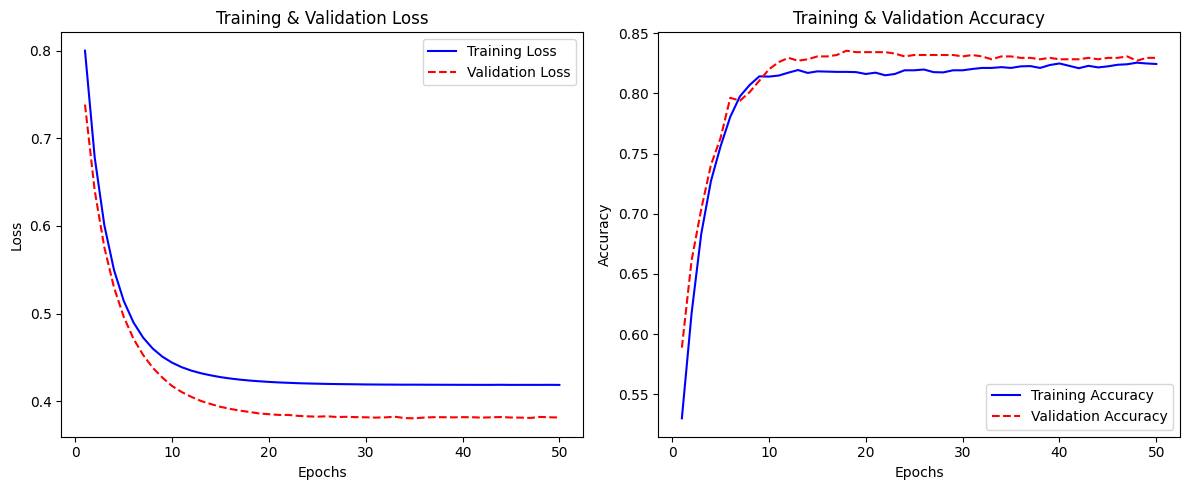

In [70]:
plot_training_history(history)

# Model 3 - Grid Search Random Forest Classifier

In [71]:
# Model 3 - Grid Search Random Forest Classifier

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
}

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_std, y_train)

# Get best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate on the validation set
y_val_pred = grid_search.best_estimator_.predict(X_val_std)
print(classification_report(y_val, y_val_pred))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters:  {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       702
           1       0.84      0.85      0.84       142

    accuracy                           0.95       844
   macro avg       0.90      0.91      0.91       844
weighted avg       0.95      0.95      0.95       844



In [72]:
#Lets print best parameters that produced our best model
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)



Best Parameters:  {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [73]:
best_GS_RFC_Model = grid_search.best_estimator_

In [74]:
joblib.dump(best_GS_RFC_Model, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

In [75]:
train_accuracy = best_GS_RFC_Model.score(X_train_std, y_train)
val_accuracy = best_GS_RFC_Model.score(X_val_std, y_val)

print(f"Grid Searched Random Forest Classifier Training Accuracy: {train_accuracy *100:.2f}%")
print(f"Grid Searched Random Forest Classifier Validation Accuracy: {val_accuracy * 100 :.2f}%")

Grid Searched Random Forest Classifier Training Accuracy: 100.00%
Grid Searched Random Forest Classifier Validation Accuracy: 94.67%


In [76]:
train_accuracy = grid_search.best_estimator_.score(X_train_std, y_train)
val_accuracy = grid_search.best_estimator_.score(X_val_std, y_val)

print(f"Grid Searched Random Forest Classifier Training Accuracy: {train_accuracy *100:.2f}%")
print(f"Grid Searched Random Forest Classifier Validation Accuracy: {val_accuracy * 100 :.2f}%")

Grid Searched Random Forest Classifier Training Accuracy: 100.00%
Grid Searched Random Forest Classifier Validation Accuracy: 94.67%


In [77]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (val_accuracy - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Grid Searched Random Forest Classifier improved accuracy over baseline by {perc_acc_improvement}%")

 Grid Searched Random Forest Classifier improved accuracy over baseline by 32.51%


# Model 4 - HistGradientBoostingClassifier comprehensive grid search

In [78]:
# HistGradientBoostingClassifier comprehensive grid search
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0, 0.1, 0.5]
}

hgb_model = HistGradientBoostingClassifier(random_state=42)

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=hgb_model, param_grid=param_grid,
    cv=5, scoring='accuracy', n_jobs=-1, verbose=2, return_train_score=True
)

grid_search.fit(X_train_std, y_train)

# Get best parameters & accuracy
best_params = grid_search.best_params_
train_accuracy = grid_search.best_estimator_.score(X_train_std, y_train)
val_accuracy = grid_search.best_estimator_.score(X_val_std, y_val)

print("Best Parameters: ", best_params)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Parameters:  {'l2_regularization': 0, 'learning_rate': 0.2, 'max_depth': None, 'max_iter': 300, 'min_samples_leaf': 20}
Training Accuracy: 0.9989
Validation Accuracy: 0.9443


In [79]:
best_GS_hgb_model = grid_search.best_estimator_

In [80]:
joblib.dump(best_GS_hgb_model, 'best_hist_grad_boost_c.pkl')

['best_hist_grad_boost_c.pkl']

In [81]:
# Get best parameters & accuracy
best_params = grid_search.best_params_
train_accuracy = best_GS_hgb_model.score(X_train_std, y_train)
val_accuracy = best_GS_hgb_model.score(X_val_std, y_val)

print("Best Parameters: ", best_params)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

Best Parameters:  {'l2_regularization': 0, 'learning_rate': 0.2, 'max_depth': None, 'max_iter': 300, 'min_samples_leaf': 20}
Training Accuracy: 0.9989
Validation Accuracy: 0.9443


In [82]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (val_accuracy - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Grid Searched Hist Gradient Boosting Classifier improved accuracy over baseline by {perc_acc_improvement}%")

 Grid Searched Hist Gradient Boosting Classifier improved accuracy over baseline by 32.18%


# Model 5: Grid Searched FFNN

In [83]:
def build_model(hp):
    inputs = keras.Input(shape=(X_train_std.shape[1],))

    # Tune the number of hidden layers (1 to 3)
    num_layers = hp.Int('num_layers', min_value=1, max_value=3)

    # First hidden layer (always present) with 'relu' activation
    x = layers.Dense(
        units=hp.Choice('num_units_layer_1', values=[32, 64, 128]),
        activation='relu'
    )(inputs)

    # Additional layers (conditionally added)
    for i in range(2, num_layers + 1):
        x = layers.Dense(
            units=hp.Choice(f'num_units_layer_{i}', values=[32, 64, 128]),
            activation='relu'
        )(x)

    # Output layer for binary classification
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=output)

    # Tune learning rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.01])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,            # Number of epochs to wait before quitting
    restore_best_weights=True
)

tuner = kt.GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_ffnn',
    project_name='ffnn_churn_prediction'
)


In [84]:
# Run search with early stopping
tuner.search(X_train_std, y_train,
             validation_data=(X_val_std, y_val),
             epochs=60,
             batch_size=32,
             callbacks=[early_stopping])



Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.8732227683067322

Best val_accuracy So Far: 0.8732227683067322
Total elapsed time: 00h 01m 05s


In [85]:
# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.get_best_models(num_models=1)[0]

In [86]:
best_model.save('best_gs_ffnn_model.h5')



In [87]:
print("Best Hyperparameters:")
print(f"  Number of Hidden Layers: {best_hps.get('num_layers')}")
for i in range(1, best_hps.get('num_layers') + 1):
    print(f"  Layer {i} - Units: {best_hps.get(f'num_units_layer_{i}')}")
print(f"  Learning Rate: {best_hps.get('learning_rate')}")

Best Hyperparameters:
  Number of Hidden Layers: 2
  Layer 1 - Units: 32
  Layer 2 - Units: 32
  Learning Rate: 0.01


In [88]:
train_acc = best_model.evaluate(X_train_std, y_train, verbose=0)[1]
val_acc = best_model.evaluate(X_val_std, y_val, verbose=0)[1]

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Training Accuracy: 0.8753
Validation Accuracy: 0.8732


In [89]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (val_acc - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Grid Searched FFNN Classifier improved accuracy over baseline by {perc_acc_improvement}%")

 Grid Searched FFNN Classifier improved accuracy over baseline by 22.23%


# Model 6. Support Vector Machine, grid searched, 5 fold cross validation

In [90]:
# Hyperparameters grid for Support Vector Machine
# We will optimize on regulatization paramter 'C'
# kernel types: linear, radial, or polynimial
# kernel coefficients for radial and polynimial kernels
# Degree for polynomial kernel
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly'
    'degree': [3, 4, 5]  # Only used for 'poly' kernel
}

# Instantiate the SVM classifier
svm = SVC()

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_std, y_train)

# Output the best parameters found
print(f"Best parameters found: {grid_search.best_params_}")


Best parameters found: {'C': 10, 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf'}


In [91]:
# Get the best model from grid search
best_svm = grid_search.best_estimator_

# Predict on the validation data
y_pred_val = best_svm.predict(X_val_std)

# Calculate and print the validation accuracy
validation_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Accuracy: 0.8673


In [92]:
joblib.dump(best_svm, 'best_svm_model.pkl')

['best_svm_model.pkl']

In [93]:
y_pred_train = best_svm.predict(X_train_std)

# Calculate and print the training accuracy
training_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {training_accuracy:.4f}")

Training Accuracy: 0.8967


In [94]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (validation_accuracy - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Grid Searched Support Vector Machine Classifier improved accuracy over baseline by {perc_acc_improvement}%")

 Grid Searched Support Vector Machine Classifier improved accuracy over baseline by 21.4%


# Model 7: K-Nearest Neighbors, grid searched, 5 fold cross validation

In [95]:
# Our hyperparameters grid for KNN
# We will optimize K-Nearest Neighbors classification on:
# Number of neighbors, weight function used in prediction,
# Distance metric to compute distance with neighbors:
# Euclidean, Minkowski, Manhattan
# Power paramater used to compute Minkowski distance

param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Distance metric
    'p': [1, 2]  # Power parameter for the Minkowski metric (1: Manhattan, 2: Euclidean)
}

# Instantiate the KNN classifier
knn = KNeighborsClassifier()

# GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_std, y_train)

# Output the best parameters found
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [96]:
# Our best model from grid search
best_knn = grid_search.best_estimator_

# Predict on the validation data
y_pred_val = best_knn.predict(X_val_std)

# Calculate validation accuracy
validation_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Accuracy: 0.9135


In [97]:
joblib.dump(best_knn, 'best_knn_model.pkl')

['best_knn_model.pkl']

In [98]:
y_pred_train = best_knn.predict(X_train_std)

# Calculate Training accuracy
validation_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {validation_accuracy:.4f}")

Training Accuracy: 1.0000


In [99]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (validation_accuracy - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Grid Searched K-Nearest Neighbor Classifier improved accuracy over baseline by {perc_acc_improvement}%")

 Grid Searched K-Nearest Neighbor Classifier improved accuracy over baseline by 39.98%


# Model 8: XGBoost Classifier, grid searched, 5 fold cross validation

XGBoost is an ensemble method that builds multiple decision trees such that each tree improves the predictions of previous trees. This ensemble method trains weak learners sequentially: each tree attempts to correct the errors made by previous trees by minimizing the residual errors. The objective function is minimizing the loss function; the loss function measures the difference between predicted and actual values.

In [100]:
param_grid = {
    'n_estimators': [50, 100, 150, 200],  # Number of boosting rounds (trees)
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate (eta)
    'max_depth': [3, 6, 9, 12],  # Maximum depth of each tree
    'subsample': [0.7, 0.8, 1.0],  # Fraction of samples used to train each tree
    'colsample_bytree': [0.7, 0.8, 1.0],  # Fraction of features used to train each tree
    'gamma': [0, 0.1, 0.2],  # Regularization parameter
}

# Instantiate the XGBoost model for binary classification (Churn prediction)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1) #use all cores
grid_search.fit(X_train_std, y_train)
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 150, 'subsample': 1.0}


In [101]:
best_xgb_model = grid_search.best_estimator_

# Predict on the validation data
y_pred_val = best_xgb_model.predict(X_val_std)

# Calculate and print the validation accuracy
validation_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Accuracy: 0.9336


In [102]:
joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

In [103]:
y_pred_train = best_xgb_model.predict(X_train_std)

# Calculate Training accuracy
validation_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {validation_accuracy:.4f}")

Training Accuracy: 0.9985


In [104]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (validation_accuracy - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Grid Searched XGBoost Classifier improved accuracy over baseline by {perc_acc_improvement}%")

 Grid Searched XGBoost Classifier improved accuracy over baseline by 39.76%


# Using XGBoost Classifier to assess feature importance.

*   For feature importance type we will use 'gain' to see how each feature contributed to gain in model accuracy.
*   Specifcally, 'gain' measures the average contribution brought by each feature when it is used in a split across all trees in the model.



In [105]:
feature_names = X_train.columns
X_train_df_xg = pd.DataFrame(X_train_std, columns=feature_names)

In [106]:
X_train_df_xg.columns

Index(['CashbackAmount', 'Complain', 'DaySinceLastOrder', 'SatisfactionScore',
       'Tenure', 'PreferredLoginDevice_Mobile_Phone',
       'PreferedOrderCat_Laptop_and_Accessory',
       'PreferedOrderCat_Mobile_Phone', 'MaritalStatus_Single'],
      dtype='object')

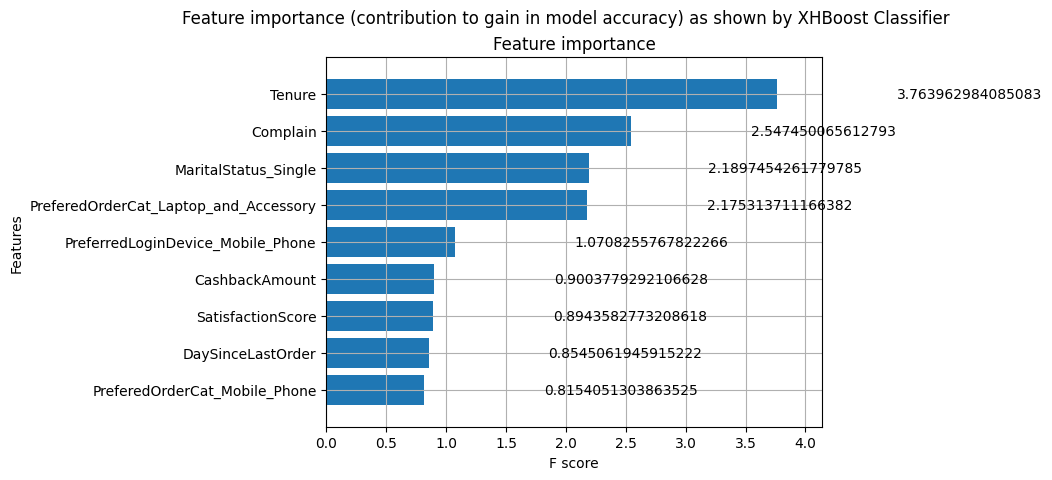

In [107]:
# Plot feature importance using 'gain'

# Set the feature names in the model
feature_names_list = list(X_train_df_xg.columns)
best_xgb_model.get_booster().feature_names = feature_names_list

# Plot feature importance using 'gain'
xgb.plot_importance(best_xgb_model, importance_type='gain', max_num_features=10, height=0.8)
plt.suptitle("Feature importance (contribution to gain in model accuracy) as shown by XHBoost Classifier")
plt.show()

# From the picture above these are the top features that contributed most to gain in model accuracy for churn prediction (by decreasing order):

  # Tenure
  # Complain
  # Marital Status Single
  # Prferred Order Category (Laptop and Accessory)

# From the model Single, complaining, customers with tenure who perferably ordered laptop and accessory are most likely to churn










2.   List item



# Model 9: Decision Tree, grid searched, 5-fold cross-validation

In [108]:
# Grid searched, 5 fold cross validation Decision Tree for our churn prediction

param_grid = {
    'max_depth': [3, 5, 7, 9, None],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],    # Minimum samples required at a leaf node
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split (impurity (gini), vs. information gain at split (entropy))
    'max_features': [None, 'sqrt', 'log2']  # Number of features to consider when looking for the best split
}

dt_model = DecisionTreeClassifier(random_state=42)

# GridSearchCV for cross-validation with 5-folds
grid_search = GridSearchCV(estimator=dt_model,
                           param_grid=param_grid,
                           cv=5,  # 5-fold cross-validation
                           scoring='accuracy',  # Optimizing for accuracy
                           n_jobs=-1)

# Fit the GridSearchCV to your training data
grid_search.fit(X_train_std, y_train)

# Output the best parameters found from the grid search
print(f"Best parameters found: {grid_search.best_params_}")

Best parameters found: {'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [109]:
best_dt_model = grid_search.best_estimator_

# Predict on the validation data
y_pred_val = best_dt_model.predict(X_val_std)

# Calculate validation accuracy
validation_accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy: {validation_accuracy:.4f}")

Validation Accuracy: 0.9360


In [110]:
joblib.dump(best_dt_model, 'best_decition_tree_model.pkl')

['best_decition_tree_model.pkl']

In [129]:
y_pred_train = best_dt_model.predict(X_train_std)

# Calculate Training accuracy
validation_accuracy = accuracy_score(y_train, y_pred_train)
print(f"Training Accuracy: {validation_accuracy:.4f}")

array([[-1.24673886, -0.64681322, -1.21660885, ..., -0.71490945,
         1.73889641,  1.42044802],
       [ 2.359403  , -0.64681322,  0.50001405, ..., -0.71490945,
        -0.57934293, -0.72899268],
       [-0.41545701, -0.64681322, -0.3582974 , ...,  1.41561382,
        -0.57934293, -0.72899268],
       ...,
       [-0.15838551, -0.64681322, -0.93050504, ...,  1.41561382,
        -0.57934293,  1.42044802],
       [-0.39202779, -0.64681322,  0.17674502, ..., -0.71490945,
         1.73889641,  1.42044802],
       [-0.13742761, -0.64681322, -0.37046792, ...,  1.41561382,
        -0.57934293, -0.72899268]])

In [112]:
frac_baseline_accuracy = baseline_accuracy / 100.
perc_acc_improvement = round(( (validation_accuracy - frac_baseline_accuracy) / frac_baseline_accuracy ) * 100.,2)
print(f" Grid Searched Decision Tree Classifier improved accuracy over baseline by {perc_acc_improvement}%")

 Grid Searched Decision Tree Classifier improved accuracy over baseline by 39.98%


In [113]:
feature_names = X_train.columns

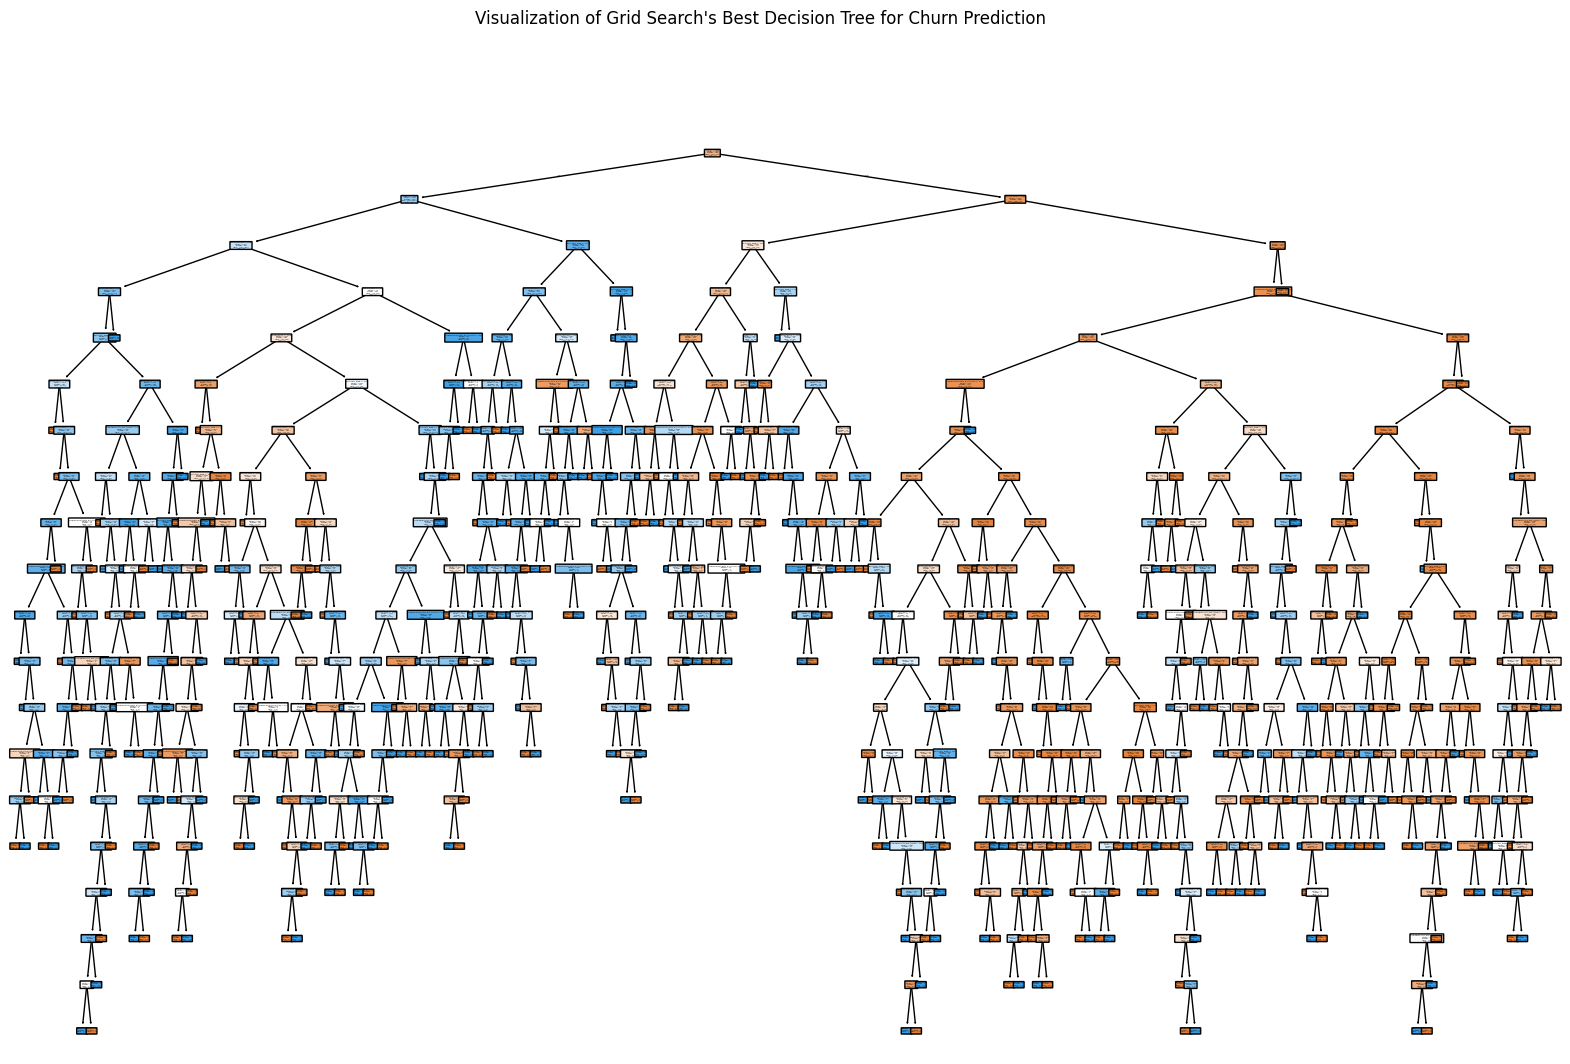

In [114]:
#Visualize our best tree
X_train_df_dt = pd.DataFrame(X_train_std, columns=feature_names)

#Use sklearn's plot_tree to visualize the bestv tree

plt.figure(figsize=(20, 12))
plot_tree(best_dt_model, filled=True, feature_names=X_train_df_dt.columns, class_names=['No', 'Yes'], rounded=True)
plt.suptitle("Visualization of Grid Search's Best Decision Tree for Churn Prediction")
plt.show()

# Summary of Model Accuracy

Model 1. Baseline Model, Baseline accuracy is: 0.7144,
Training accuracy: 0.7144
Validation accuracy: -.7144
Improvement over baseline 0%


Model 2: Logistic Regression,

Final Training Accuracy: 0.8260
Final Validation Accuracy: 0.8270,
Logistic Regression Model improved over baseline by 15.76%

Model 3 - Grid Search Random Forest Classifier

Grid Searched Random Forest Classifier Training Accuracy: 100.00%
Grid Searched Random Forest Classifier Validation Accuracy: 94.67%
Grid Searched Random Forest Classifier improved accuracy over baseline by 32.51%

Model 4 - HistGradientBoostingClassifier comprehensive grid search

Training Accuracy: 0.9989
Validation Accuracy: 0.9443
Grid Searched Hist Gradient Boosting Classifier improved accuracy over baseline by 32.18%

Model 5: Grid Searched FFNN

Training Accuracy: 0.8520
Validation Accuracy: 0.8661
Grid Searched FFNN Classifier improved accuracy over baseline by 21.24%

Model 6. Support Vector Machine, grid searched, 5 fold cross validation

Training Accuracy: 0.8967
Validation Accuracy: 0.8673
Grid Searched Support Vector Machine Classifier improved accuracy over baseline by 21.4%

Model 7: K-Nearest Neighbors, grid searched, 5 fold cross validation

Training Accuracy: 1.0000
Validation Accuracy: 0.9135
Grid Searched K-Nearest Neighbor Classifier improved accuracy over baseline by 27.87%

Model 8: XGBoost Classifier, grid searched, 5 fold cross validation

Training Accuracy: 0.9985
Validation Accuracy: 0.9336
Grid Searched XGBoost Classifier improved accuracy over baseline by 30.69%

Model 9: Decision Tree, grid searched, 5-fold cross-validation

Training Accuracy: 1.0000
Validation Accuracy: 0.9360
Grid Searched Decision Tree Classifier improved accuracy over baseline by 31.02%



In [115]:
models = [
    "Baseline Model",
    "Logistic Regression",
    "Grid-RFC",
    "Grid-HGBC",
    "Grid-FFNN",
    "Grid-SVC",
    "Grid-KNN",
    "Grid-XGBoost",
    "Grid-DecisionTree "
]

training_accuracies = [
    0.7144,
    0.8260,
    1.0000,
    0.9989,
    0.8520,
    0.8967,
    1.0000,
    0.9985,
    1.0000
]

validation_accuracies = [
    0.7144,
    0.8270,
    0.9467,
    0.9443,
    0.8661,
    0.8673,
    0.9135,
    0.9336,
    0.9360
]

improvements = [
    "0%",
    "15.76%",
    "32.51%",
    "32.18%",
    "21.24%",
    "21.4%",
    "27.87%",
    "30.69%",
    "31.02%"
]

improvements = [ float(val.strip('%')) for val in improvements ]


# Create the DataFrame
df = pd.DataFrame({
    'Model': models,
    'Training Accuracy': training_accuracies,
    'Validation Accuracy': validation_accuracies,
    'Improvement over Baseline (%)': improvements
})

# Display the table
pd.set_option('display.float_format', '{:.2f}'.format)


In [116]:
df

,Model,Training Accuracy,Validation Accuracy,Improvement over Baseline (%)
0,Baseline Model,0.71,0.71,0.00
1,Logistic Regression,0.83,0.83,15.76
2,Grid-RFC,1.00,0.95,32.51
3,Grid-HGBC,1.00,0.94,32.18
4,Grid-FFNN,0.85,0.87,21.24
5,Grid-SVC,0.90,0.87,21.40
6,Grid-KNN,1.00,0.91,27.87
7,Grid-XGBoost,1.00,0.93,30.69
8,Grid-DecisionTree,1.00,0.94,31.02


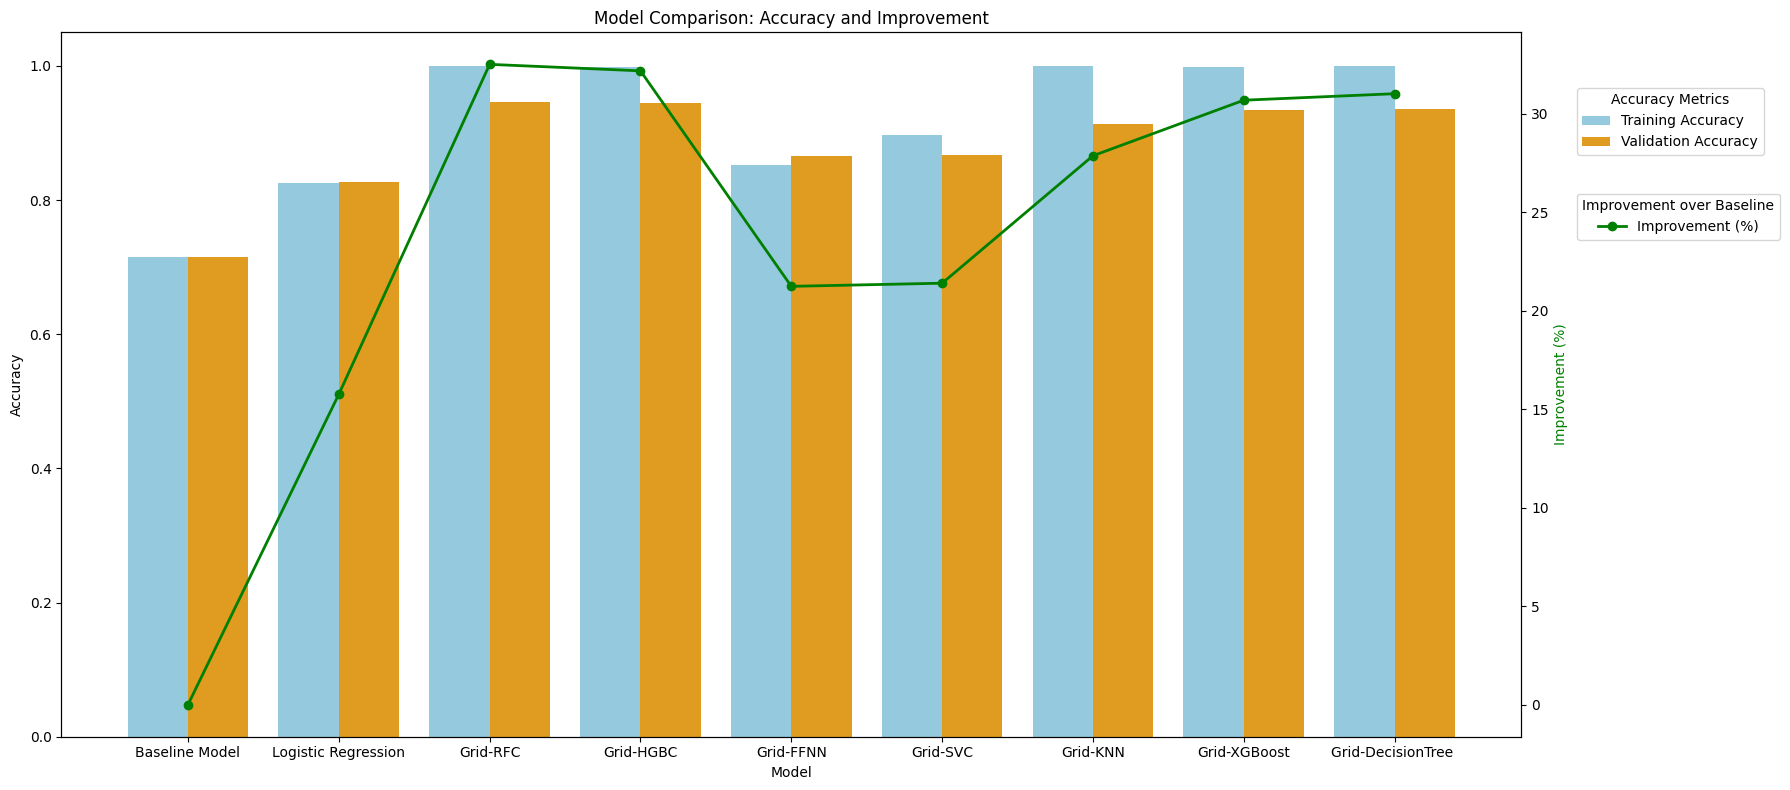

In [117]:
# Reshape for seaborn
df_melted = df.melt(id_vars='Model', value_vars=['Training Accuracy', 'Validation Accuracy'],
                    var_name='Metric', value_name='Value')


fig, ax1 = plt.subplots(figsize=(18, 8))

# Plot Training and Validation Accuracy with Seaborn
sns.barplot(x='Model', y='Value', hue='Metric', data=df_melted, palette=['skyblue', 'orange'], ax=ax1)

# Second y-axis for Improvement over Baseline
ax2 = ax1.twinx()

# Improvement over Baseline plot
ax2.plot(df['Model'], df['Improvement over Baseline (%)'], color='green', marker='o', label='Improvement (%)', linewidth=2)
ax2.set_ylabel('Improvement (%)', color='green')

ax1.set_ylabel('Accuracy')
ax1.set_title('Model Comparison: Accuracy and Improvement')
plt.xticks(rotation=90)
ax1.legend(title='Accuracy Metrics', loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=4)
ax2.legend(title='Improvement over Baseline', loc='upper left', bbox_to_anchor=(1, 0.85), borderaxespad=4)

plt.tight_layout()
plt.show()


# 'Grid RFC' (Grid-search produced BEST Random Forest Classifier) has the best Validation Accuracy, and thus most improvement over baseline.

# We will use 'Grid-RFC' to evaluate on test data

In [118]:
import os
print(os.getcwd())  # Get the current working directory


/content


In [119]:
os.listdir()

['.config',
 'best_hist_grad_boost_c.pkl',
 'my_ecomm_data_frame.csv',
 'keras_tuner_ffnn',
 'drive',
 'best_xgb_model.pkl',
 'logistic_regression_model.pkl',
 'best_gs_ffnn_model.h5',
 'best_svm_model.pkl',
 'best_knn_model.pkl',
 'best_random_forest_model.pkl',
 'best_decition_tree_model.pkl',
 'sample_data']

# Save the models to drive for download

In [120]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
import os

drive_folder = '/content/drive/MyDrive/VS_models'
os.makedirs(drive_folder, exist_ok=True)

In [122]:
import shutil

model_files = [
    'best_gs_ffnn_model.h5',
    'best_knn_model.pkl',
    'best_xgb_model.pkl',
    'best_hist_grad_boost_c.pkl',
    'best_svm_model.pkl',
    'best_decition_tree_model.pkl',
    'logistic_regression_model.pkl',
    'best_random_forest_model.pkl'
]

for file in model_files:
    shutil.copy(file, drive_folder)

In [123]:
# Load models
base_model_path = '/content/drive/MyDrive/VS_models/'

In [125]:
model_files = {
    'ffnn_model': 'best_gs_ffnn_model.h5',
    'knn_model': 'best_knn_model.pkl',
    'xgb_model': 'best_xgb_model.pkl',
    'hist_grad_boost_model': 'best_hist_grad_boost_c.pkl',
    'svm_model': 'best_svm_model.pkl',
    'decision_tree_model': 'best_decition_tree_model.pkl',
    'logistic_regression_model': 'logistic_regression_model.pkl',
    'random_forest_model': 'best_random_forest_model.pkl'
}


In [126]:
models = {}

# Load Keras model (FFNN)
models['ffnn_model'] = load_model(base_model_path + model_files['ffnn_model'])

# Load scikit-learn models
models['knn_model'] = joblib.load(base_model_path + model_files['knn_model'])
models['xgb_model'] = joblib.load(base_model_path + model_files['xgb_model'])
models['hist_grad_boost_model'] = joblib.load(base_model_path + model_files['hist_grad_boost_model'])
models['svm_model'] = joblib.load(base_model_path + model_files['svm_model'])
models['decision_tree_model'] = joblib.load(base_model_path + model_files['decision_tree_model'])
models['logistic_regression_model'] = joblib.load(base_model_path + model_files['logistic_regression_model'])
models['random_forest_model'] = joblib.load(base_model_path + model_files['random_forest_model'])




In [135]:
model_data = []

# Loop through each model and calculate training and validation accuracy
for model_name, model in models.items():
    if model_name == 'ffnn_model' or model_name == 'logistic_regression_model':  # Keras model
        # Evaluate the Keras model (FFNN)
        print(f" Evaluating {model_name}")
        train_loss, train_acc = model.evaluate(X_train_std, y_train, verbose=0)
        val_loss, val_acc = model.evaluate(X_val_std, y_val, verbose=0)
        model_params = model.optimizer.get_config()  # Get optimizer params (e.g., learning rate)
        learning_rate = model_params.get('learning_rate', 'N/A')
    else:  # scikit-learn models
        # Calculate accuracy for scikit-learn models using score method
        print(f" Evaluating {model_name}")
        train_acc = model.score(X_train_std, y_train)
        val_acc = model.score(X_val_std, y_val)
        model_params = model.get_params()  # Get model parameters
        learning_rate = 'N/A'  # Not applicable for most scikit-learn models

    # Append the model data to the list
    model_data.append({
        'Model Name': model_name,
        'Learning Rate': learning_rate,
        'Training Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Model Parameters': model_params
    })

# Convert the model data list into a DataFrame
model_df = pd.DataFrame(model_data)

 Evaluating ffnn_model
 Evaluating knn_model
 Evaluating xgb_model
 Evaluating hist_grad_boost_model
 Evaluating svm_model
 Evaluating decision_tree_model
 Evaluating logistic_regression_model
 Evaluating random_forest_model


In [136]:
model_df

,Model Name,Learning Rate,Training Accuracy,Validation Accuracy,Model Parameters
0,ffnn_model,0.01,0.88,0.87,"{'name': 'adam', 'learning_rate': 0.0099999997..."
1,knn_model,N/A,1.00,0.91,"{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
2,xgb_model,N/A,1.00,0.93,"{'objective': 'binary:logistic', 'base_score':..."
3,hist_grad_boost_model,N/A,1.00,0.94,"{'categorical_features': 'from_dtype', 'class_..."
4,svm_model,N/A,0.90,0.87,"{'C': 10, 'break_ties': False, 'cache_size': 2..."
5,decision_tree_model,N/A,1.00,0.94,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
6,logistic_regression_model,0.00,0.82,0.83,"{'name': 'adam', 'learning_rate': 0.0010000000..."
7,random_forest_model,N/A,1.00,0.95,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_..."


In [141]:
baseline_accuracy_f = baseline_accuracy / 100.0

In [145]:
model_df['% Improve Over Baseline'] = model_df['Validation Accuracy'].apply(lambda x: round((x / baseline_accuracy_f - 1) * 100,2))

In [146]:
model_df

,Model Name,Learning Rate,Training Accuracy,Validation Accuracy,Model Parameters,% Improve Over Baseline
0,ffnn_model,0.01,0.88,0.87,"{'name': 'adam', 'learning_rate': 0.0099999997...",22.23
1,knn_model,N/A,1.00,0.91,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",27.87
2,xgb_model,N/A,1.00,0.93,"{'objective': 'binary:logistic', 'base_score':...",30.69
3,hist_grad_boost_model,N/A,1.00,0.94,"{'categorical_features': 'from_dtype', 'class_...",32.18
4,svm_model,N/A,0.90,0.87,"{'C': 10, 'break_ties': False, 'cache_size': 2...",21.40
5,decision_tree_model,N/A,1.00,0.94,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",31.02
6,logistic_regression_model,0.00,0.82,0.83,"{'name': 'adam', 'learning_rate': 0.0010000000...",16.10
7,random_forest_model,N/A,1.00,0.95,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",32.51


In [152]:
model_df['Abs(Gap VA-TA)'] = abs(model_df['Validation Accuracy'] - model_df['Training Accuracy'])

In [153]:
model_df

,Model Name,Learning Rate,Training Accuracy,Validation Accuracy,Model Parameters,% Improve Over Baseline,Gap VA-TA,Abs(Gap VA-TA)
0,ffnn_model,0.01,0.88,0.87,"{'name': 'adam', 'learning_rate': 0.0099999997...",22.23,0.00,0.00
1,knn_model,N/A,1.00,0.91,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",27.87,0.09,0.09
2,xgb_model,N/A,1.00,0.93,"{'objective': 'binary:logistic', 'base_score':...",30.69,0.06,0.06
3,hist_grad_boost_model,N/A,1.00,0.94,"{'categorical_features': 'from_dtype', 'class_...",32.18,0.05,0.05
4,svm_model,N/A,0.90,0.87,"{'C': 10, 'break_ties': False, 'cache_size': 2...",21.40,0.03,0.03
5,decision_tree_model,N/A,1.00,0.94,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",31.02,0.06,0.06
6,logistic_regression_model,0.00,0.82,0.83,"{'name': 'adam', 'learning_rate': 0.0010000000...",16.10,0.01,0.01
7,random_forest_model,N/A,1.00,0.95,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",32.51,0.05,0.05


In [154]:
model_df_sorted = model_df.sort_values(by=['% Improve Over Baseline', 'Abs(Gap VA-TA)'], ascending=[False, False])
model_df_sorted

,Model Name,Learning Rate,Training Accuracy,Validation Accuracy,Model Parameters,% Improve Over Baseline,Gap VA-TA,Abs(Gap VA-TA)
7,random_forest_model,N/A,1.00,0.95,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",32.51,0.05,0.05
3,hist_grad_boost_model,N/A,1.00,0.94,"{'categorical_features': 'from_dtype', 'class_...",32.18,0.05,0.05
5,decision_tree_model,N/A,1.00,0.94,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",31.02,0.06,0.06
2,xgb_model,N/A,1.00,0.93,"{'objective': 'binary:logistic', 'base_score':...",30.69,0.06,0.06
1,knn_model,N/A,1.00,0.91,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",27.87,0.09,0.09
0,ffnn_model,0.01,0.88,0.87,"{'name': 'adam', 'learning_rate': 0.0099999997...",22.23,0.00,0.00
4,svm_model,N/A,0.90,0.87,"{'C': 10, 'break_ties': False, 'cache_size': 2...",21.40,0.03,0.03
6,logistic_regression_model,0.00,0.82,0.83,"{'name': 'adam', 'learning_rate': 0.0010000000...",16.10,0.01,0.01


# Final Model Selection

  # Our criteria for final model selection:
    # Select top 3-4 models that have highest Validation Accuracy
    # From this compare their respective deltas b/w their validation accuracy and training accuracy
    # Down select models from this list that have relatively high gaps b/w Validation accuracy and training accuracy
    

# From the table above, Models 7, 3, 5, and 2 (Random Forest Classifier (RFC), HGBC, Decision Tree, XGBoost respectively) have the highest validation accuracy. Of these, RFC has the highest validation accuracy (0.95) and least gap between validation and training accuracy (0.05)

# Thus, our final model is Model 7, Random Forest Classifier

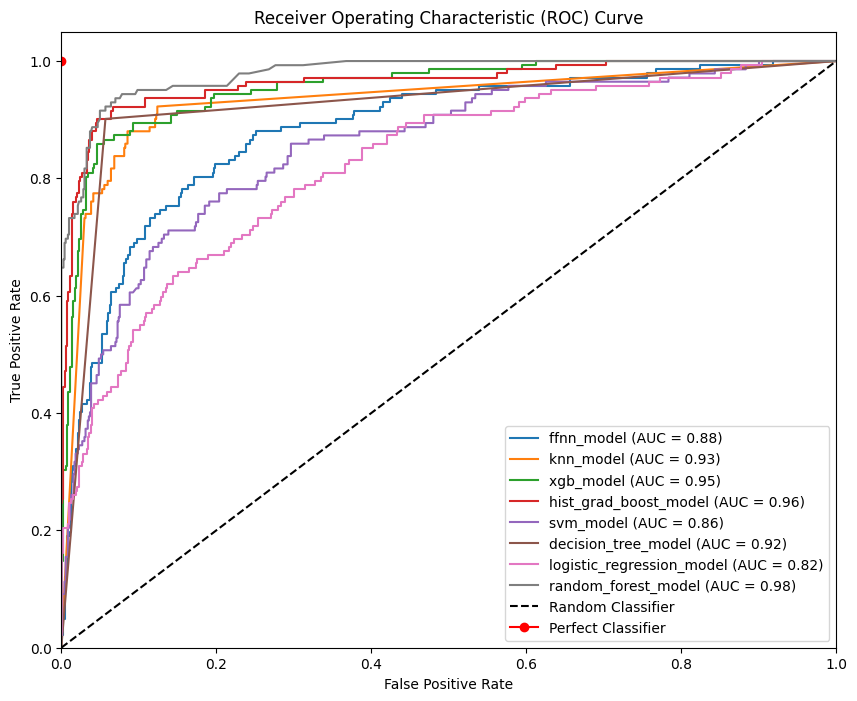

In [157]:
# But before Inference, lets plot the ROC curve of all the models
from sklearn.metrics import roc_curve, auc

# Initialize a figure for plotting
plt.figure(figsize=(10, 8))

# Loop through all models to plot their ROC curves
for model_name, model in models.items():
    if model_name == 'ffnn_model' or model_name == 'logistic_regression_model':  # Keras models
        # Get predicted probabilities for the positive class (sigmoid output)
        y_pred_proba = model.predict(X_val_std, verbose=0)

        # If the output is of shape (n_samples, 1), we flatten it to get a 1D array of probabilities
        y_pred_proba = y_pred_proba.flatten()
    elif model_name == 'svm_model':
      models['svm_model'] = SVC(probability=True)
      models['svm_model'].fit(X_train_std, y_train)
      y_pred_proba = models['svm_model'].predict_proba(X_val_std)[:, 1]
    else:  # scikit-learn models
        # Get predicted probabilities for the positive class
        y_pred_proba = model.predict_proba(X_val_std)[:, 1]  # For binary classification (second column)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot random classifier (diagonal line)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize the plot
plt.plot([0], [1], marker='o', color='red', label='Perfect Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

# Time for inference, Analysis commentary in the end

In [159]:
print(X_test_std.shape, y_test.shape)

(845, 9) (845,)


In [162]:
X_test_std.head()

,CashbackAmount,Complain,DaySinceLastOrder,SatisfactionScore,Tenure,PreferredLoginDevice_Mobile_Phone,PreferedOrderCat_Laptop_and_Accessory,PreferedOrderCat_Mobile_Phone,MaritalStatus_Single
3809,224.24,0,3.00,4,12.00,1.00,1.00,0.00,0.00
2456,201.69,0,9.00,1,16.00,1.00,0.00,0.00,0.00
4498,186.18,0,3.00,3,4.00,1.00,1.00,0.00,0.00
1775,142.30,0,3.00,3,8.00,0.00,0.00,1.00,1.00
938,186.20,0,4.00,3,2.00,1.00,1.00,0.00,0.00


In [161]:
y_test[:3]

array([0, 1, 0])

In [169]:
best_model_ = models['random_forest_model']


In [170]:
y_pred_test = best_model_.predict(X_test_std)

In [171]:
y_pred_test.shape

(845,)

In [175]:
y_test.shape

(845,)

In [173]:
type(best_model_)

sklearn.ensemble._forest.RandomForestClassifier

In [177]:
rfc_test_accuracy = accuracy_score(y_test, y_pred_test)

print("_"*125)
print("_"*125)
print(f"Final Model (RFC) Test Accuracy: {rfc_test_accuracy}")
print("_"*125)
print("_"*125)


_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________
Final Model (RFC) Test Accuracy: 0.9668639053254438
_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


In [179]:

print("_"*125)
print("_"*125)
print(f"Classification Report (Inference)")
print(classification_report(y_test, y_pred_test))
print("_"*125)
print("_"*125)



_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________
Classification Report (Inference)
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       703
           1       0.91      0.89      0.90       142

    accuracy                           0.97       845
   macro avg       0.94      0.94      0.94       845
weighted avg       0.97      0.97      0.97       845

_____________________________________________________________________________________________________________________________
_____________________________________________________________________________________________________________________________


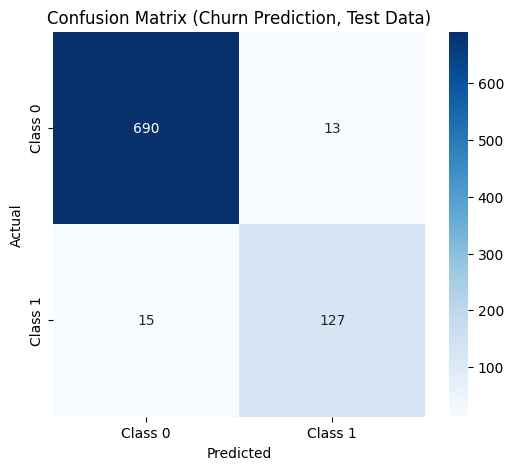

In [182]:
#
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'], cbar=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Churn Prediction, Test Data)')
plt.show()

In [183]:
cm

array([[690,  13],
       [ 15, 127]])

In [184]:
y_test.shape

(845,)

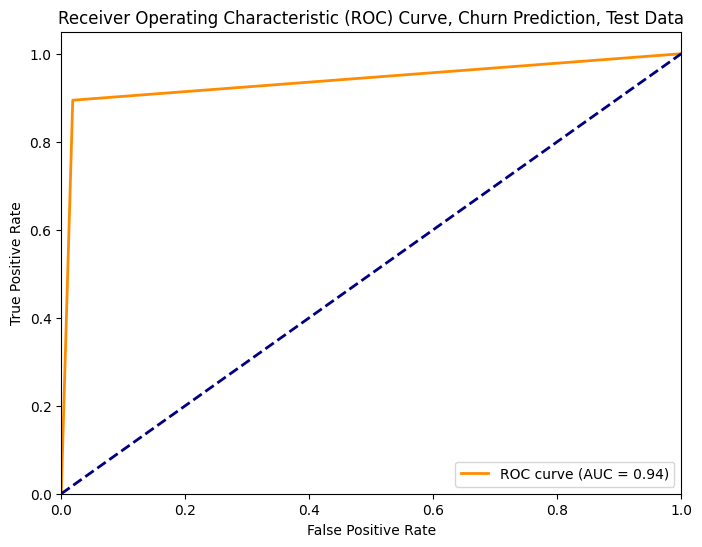

In [189]:
# Test Data: ROC curve and ROC area for the model
fpr, tpr, _ = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

# ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve, Churn Prediction, Test Data')
plt.legend(loc='lower right')
plt.show()

# Generalization / Inference Analysis

Definitions:
* Precision: Out of all the instances that were predicted as "churned" (class 1), how many were actually "churned" (class 1).

* Recall: Out of all the actual churned customers, how many were correctly identified as churned.

* F1-score is the harmonic mean of precision and recall. It is a balanced metric that gives a single value to assess the model's performance when both precision and recall are important, especially in cases where you have an imbalanced dataset. The F1-score ranges from 0 to 1, where 1 is the best performance, meaning both precision and recall are perfect.

Analysis:

* From Classification report output above, Test accuracy is 0.97 (Training accuracy was 1, Validation Accuracy was 0.95). Model has generalized well. Its test accuracy is closer to training accuracy, and higher than validation accuracy.

* From Classification report output above, macro level precision, recall and F1 scores are equal, and high, which indicates good model performance on test data. Precision and recall on Churned class is lower than the same on Not Churned class which can be expected since Not Churned is the majority class (model has more samples to learn for the Not Churned class), even though we used SMOTE to account for class imbalance (some imbalance could still have remained).

* From Confusion matrix, Class 1 (Churned) confuses more, but this is to be expected as well from the reasoning above.

* From ROC curve, AUC (Area under the curve) is 0.94 which compares favorably with an AUC of 1 for a perfect classifier.

Overall, our best model has generalized well and we recommend it to be taken to production to meet the real world data.